In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from sipm.sipm import gauss, compound_poisson
from scipy.optimize import curve_fit
from scipy.special import erf, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

# Top tile calibration (1101 data)

## Directories

In [4]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/'
bias = [61, 63, 65, 67, 69]
subdir = ['2022-11-01_volt_{}_pos_top_light_laser_coinc_none_cond_calibration/'.format(bias_) for bias_ in bias]

In [5]:
datasets_top = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=4000)
    for i in range(4):
        data.ch[i].read_data(header=True)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].clear()
    datasets_top.append(data)

## Plot filtered amplitude histogram and analyze
Here we look at the prompt amplitude of AR-filtered waveforms ($A_{\rm filt}$).<br>
The PE peaks in the histograms are fitted with Gaussian $(N_k, A_k, \sigma_k)$, where $k$ is PE count.<br>
$(k, A_k)$ is fitted with linear function $A_k = Q_A \times k  + b$.<br>
$(V, Q_A)$ is then fitted with linear function for breakdown voltage $Q_A = C(V-V_{bd})$.<br>
$(k, N_k)$ is fitted with Vinogradov model (Compound Poisson) where $\mu$ is laser intensity and $p$ is DiCT probability.<br>

mu=2.281 p=0.083
mu=2.535 p=0.140
mu=2.648 p=0.204
mu=2.752 p=0.256
mu=2.850 p=0.317
Channel 0 Vbd=55.029+/-0.051V slope=9.703+/-0.050
mu=3.079 p=0.117
mu=3.501 p=0.152
mu=3.736 p=0.188
mu=3.885 p=0.247
mu=3.931 p=0.300
Channel 1 Vbd=54.929+/-0.088V slope=8.696+/-0.081
mu=2.273 p=0.092
mu=2.706 p=0.081
mu=2.689 p=0.193
mu=2.762 p=0.250
mu=2.791 p=0.340
Channel 2 Vbd=55.000+/-0.053V slope=8.142+/-0.040
mu=3.321 p=0.099
mu=3.696 p=0.157
mu=3.901 p=0.206
mu=4.075 p=0.270
mu=4.080 p=0.347
Channel 3 Vbd=54.830+/-0.108V slope=9.557+/-0.094


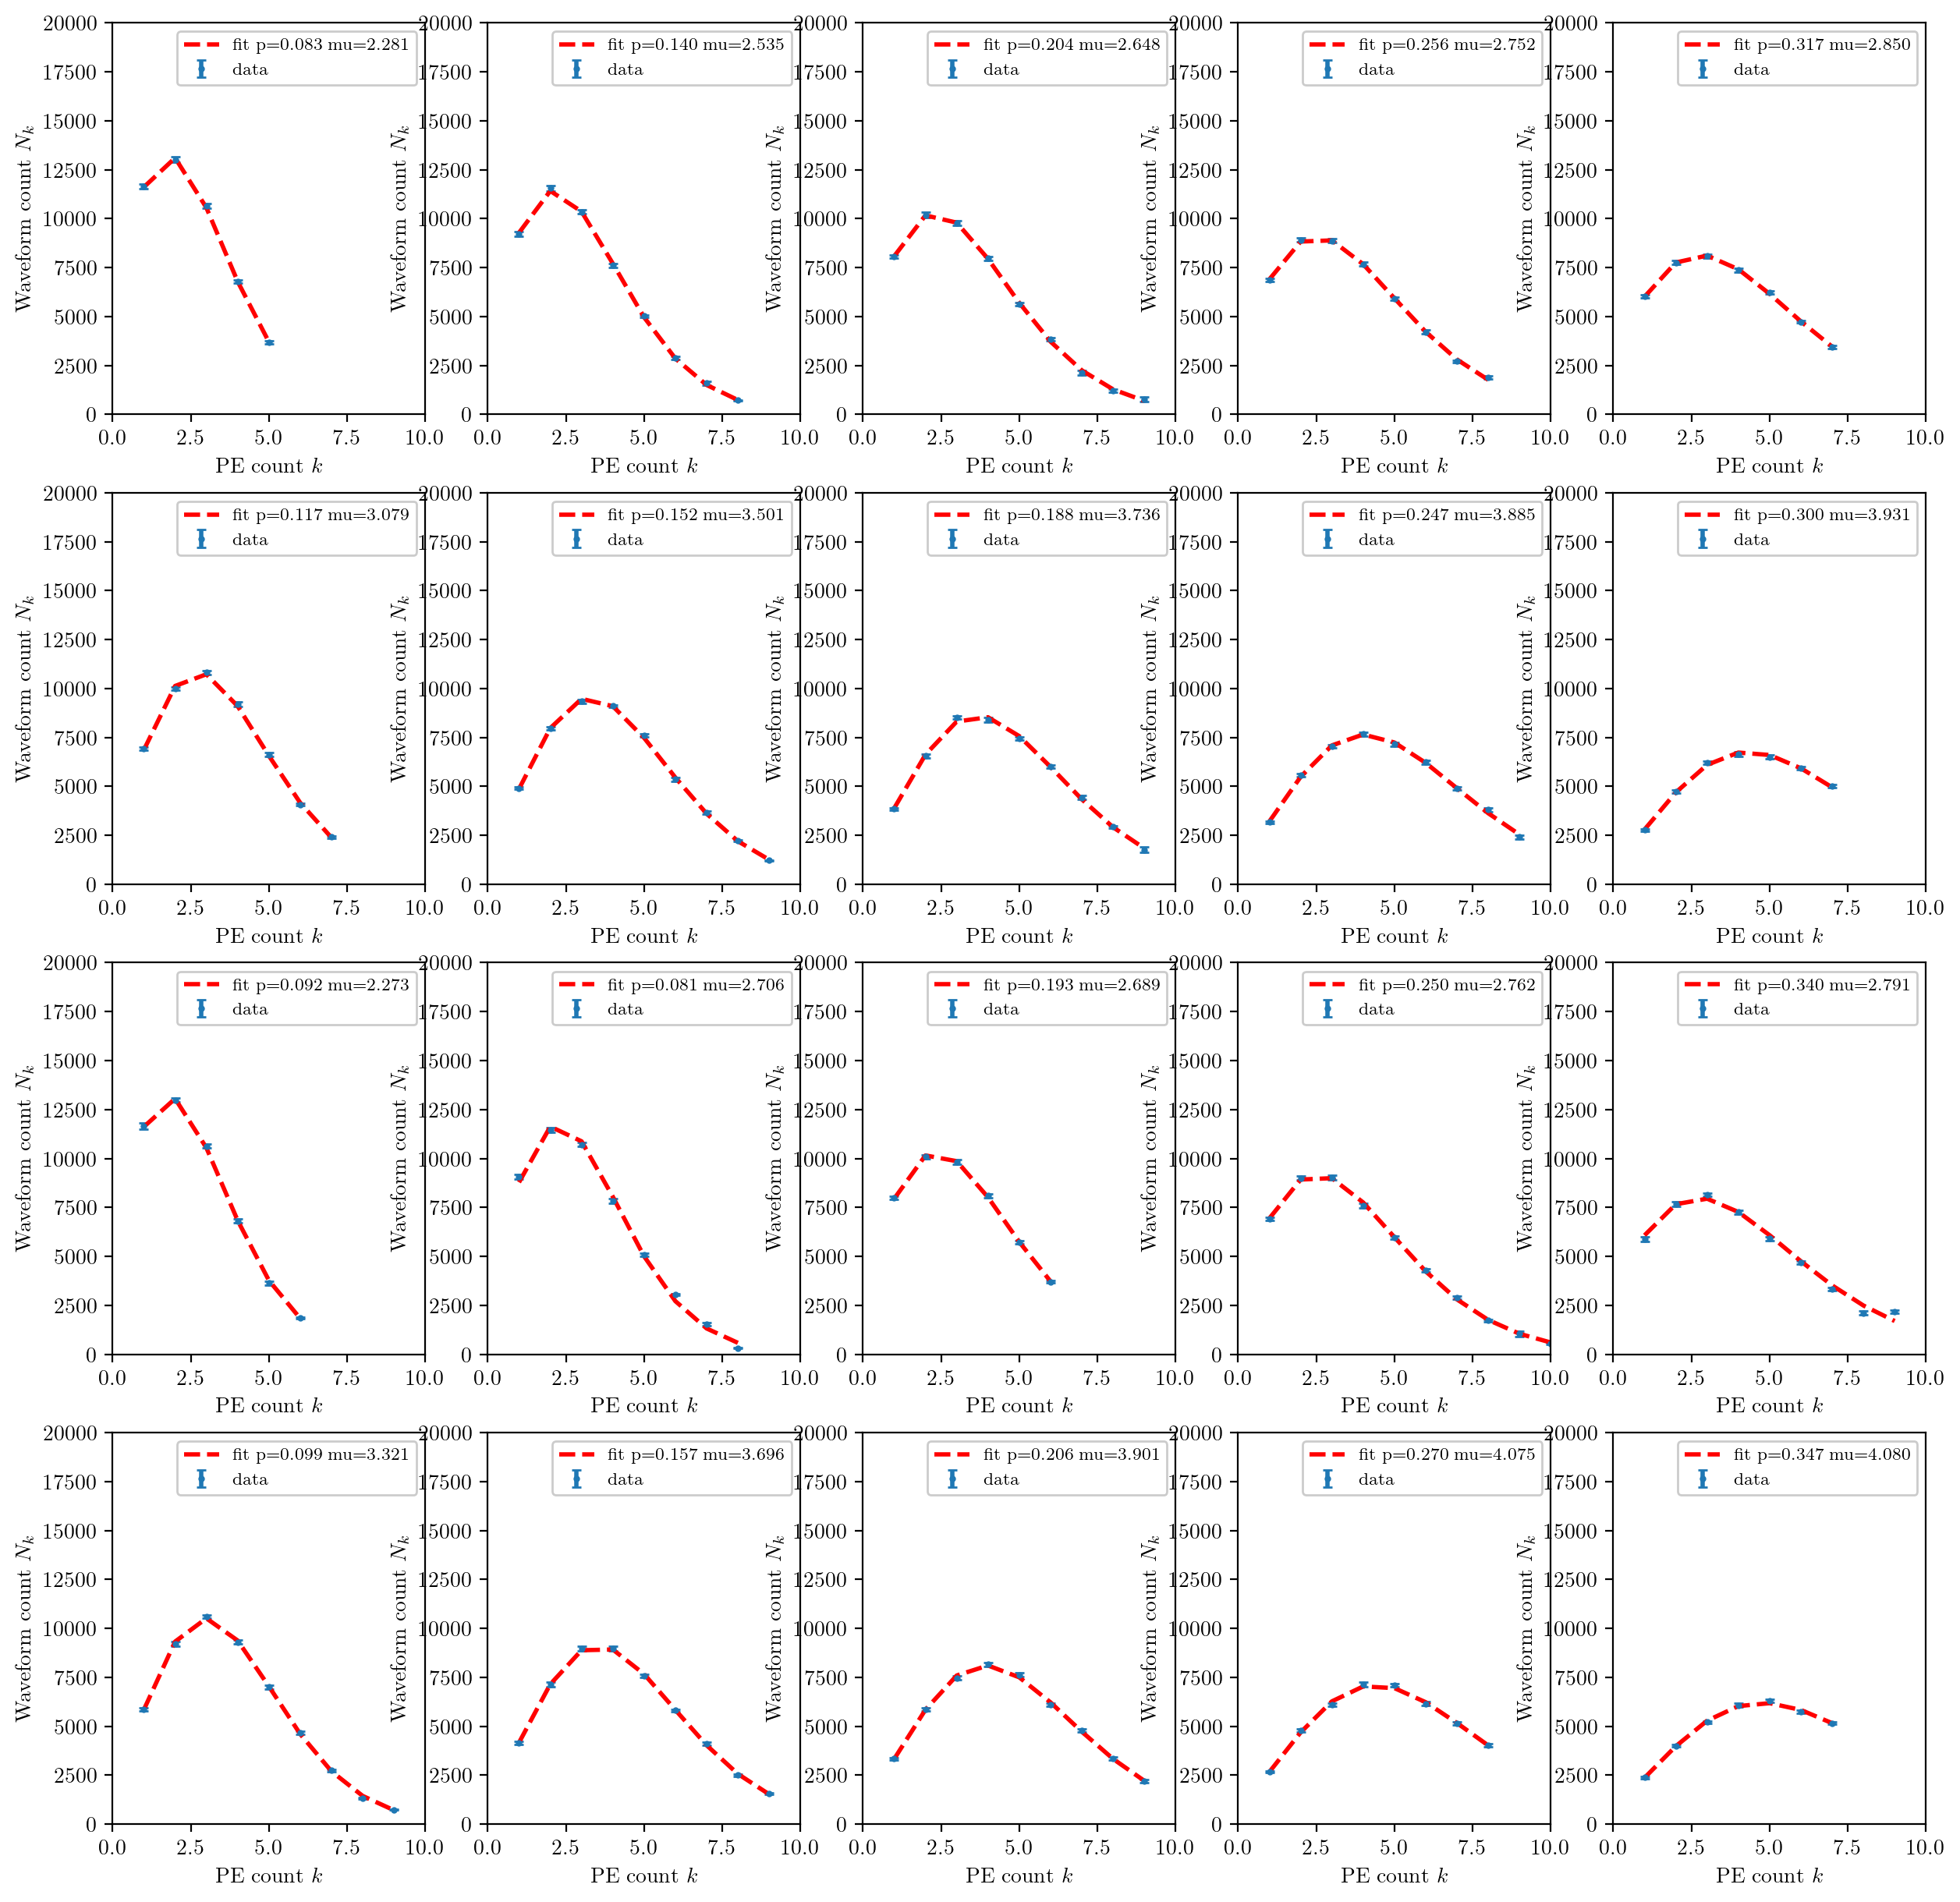

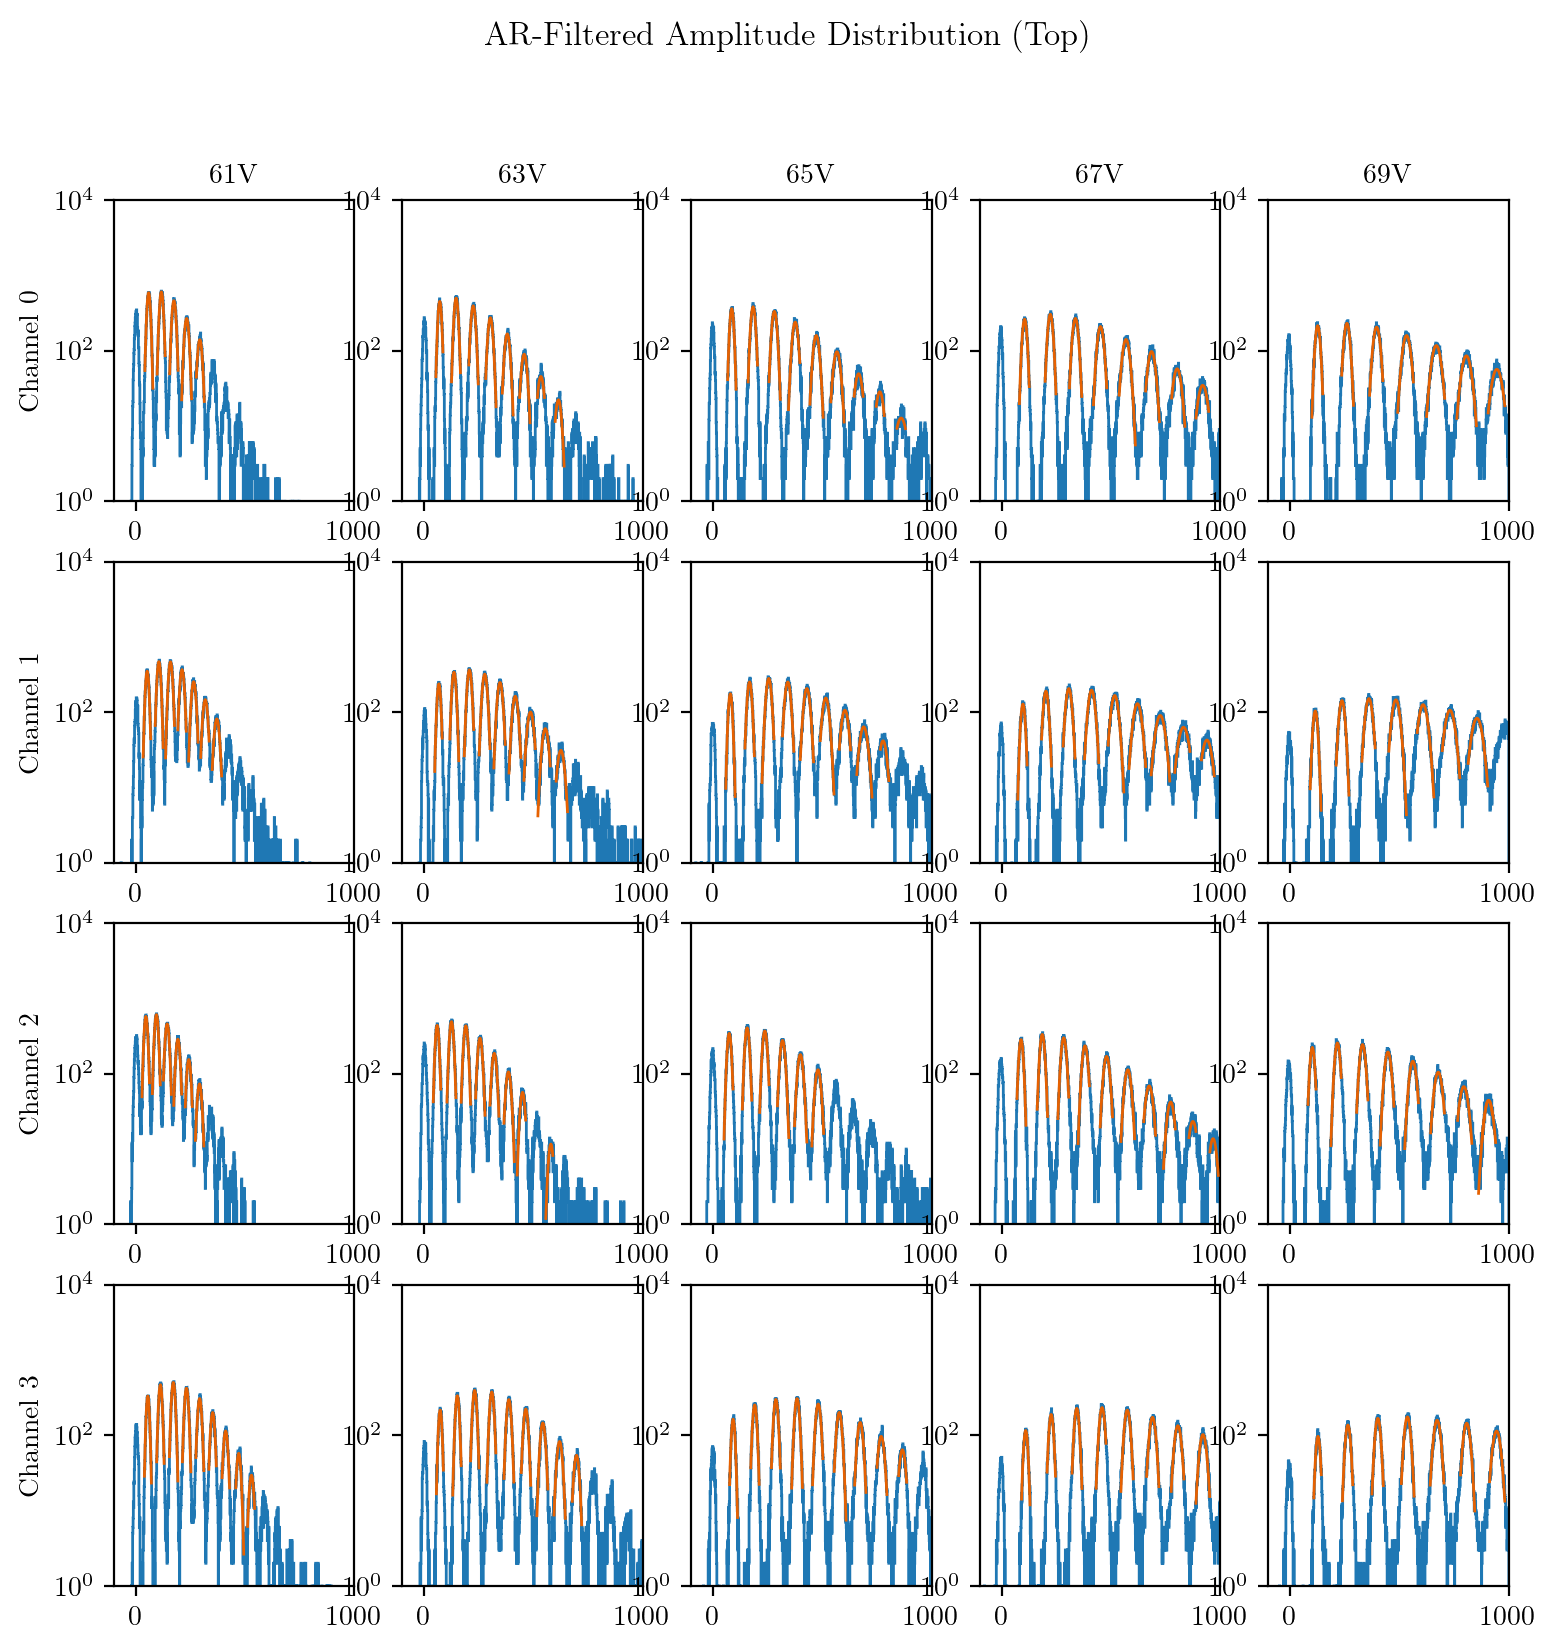

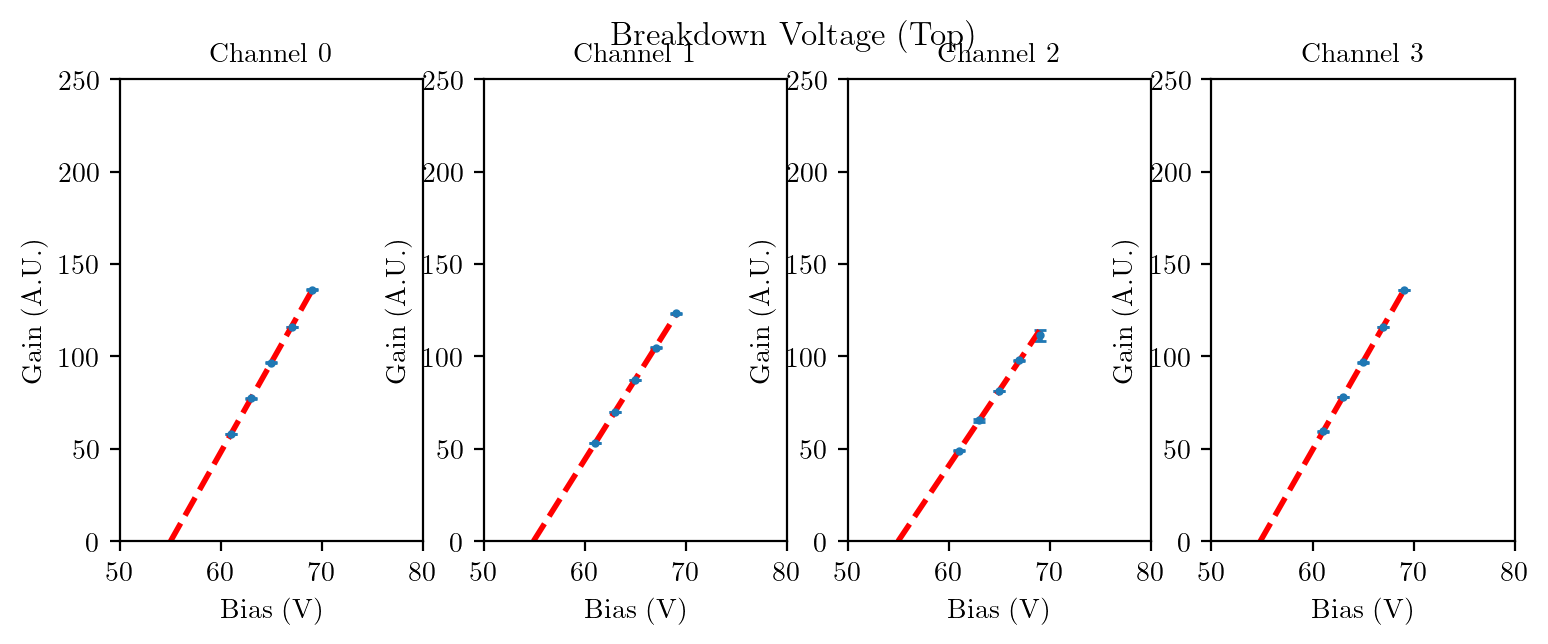

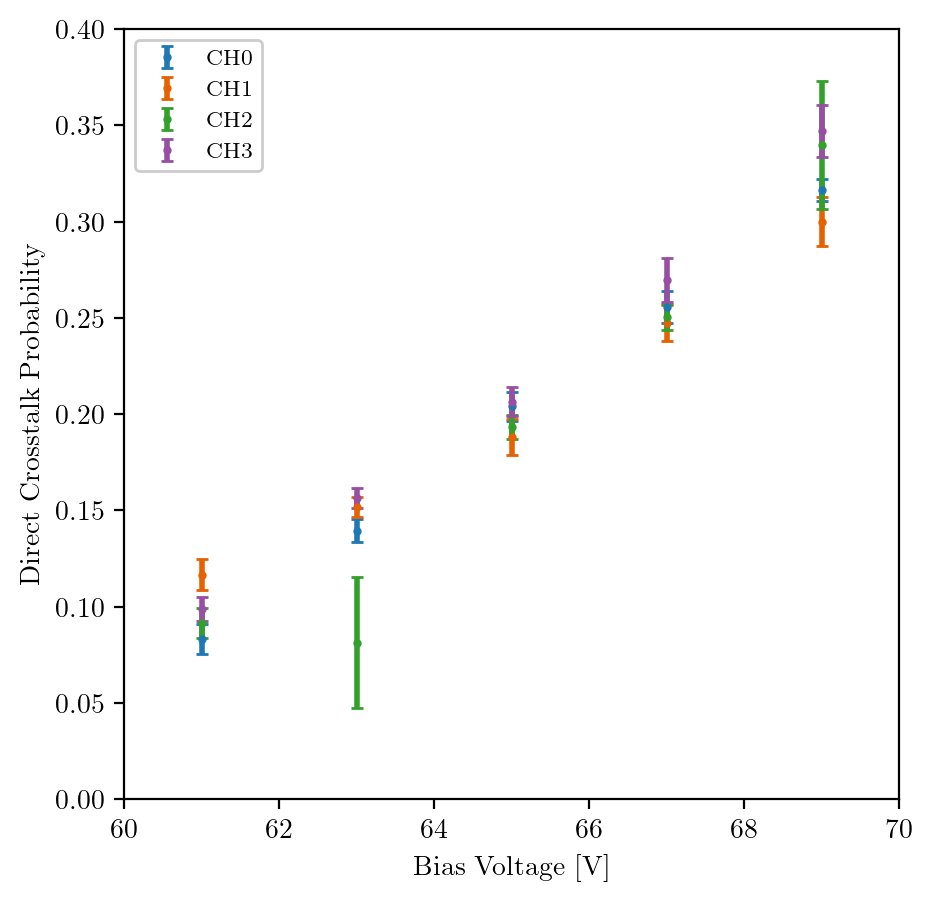

In [7]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_top):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-1e2,1e3,1000])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=100, prom=8, wid=15, dist=10)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 2, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].nevents)
        plt.xlim(0,10)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets_top], yerr=[data.ch[ch].ct[1] for data in datasets_top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in datasets_top]
    err = [data.ch[ch].q_a[1] for data in datasets_top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
plt.savefig('plots/sipm/famp_histo_top_1101.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_famp_top_1101.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4)
plt.savefig('plots/sipm/dict_top_1101.pdf')

## Afterpulsing
Here we look at the raw waveform integrals over $5~\mu s$ ($I_{\rm long}$).<br>
They are grouped by the prompt filtered amplitude $A_{\rm filt}$.<br>
If $|A_{\rm filt}-A_k|<3\sigma_k$, assign $I_{\rm long}$ to $I_k$.<br>
$I_k$ is fitted by a Gaussian $(N_{k,\rm peak}, I_{k,\rm peak}, \sigma_{k,\rm peak})$.<br>
$(k, I_k)$ is fitted by a linear function $I_{k,\rm peak} = Q_{\rm peak}\times k + b$.<br>
Define $I_{k,\rm avg}\equiv \overline{I_{k}}$.<br>
$(k, I_{k, \rm avg})$ is fitted by a linear function $I_{k, \rm avg} = Q_{\rm avg} \times k + b$.<br>
Define afterpulse charge $Q_{\rm AP} \equiv \frac{Q_{\rm avg}}{Q_{\rm peak}}-1$.<br>
$Q_{\rm peak}$ is then fitted by the linear function for breakdown voltage $Q_{\rm peak} = C(V-V_{bd})$.<br>

Channel 0 Vbd=53.488+/-0.308V slope=47.853+/-1.180
Channel 1 Vbd=53.761+/-0.129V slope=48.299+/-0.560
Channel 2 Vbd=53.944+/-0.079V slope=47.426+/-0.302


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Channel 3 Vbd=53.794+/-0.259V slope=48.405+/-1.098


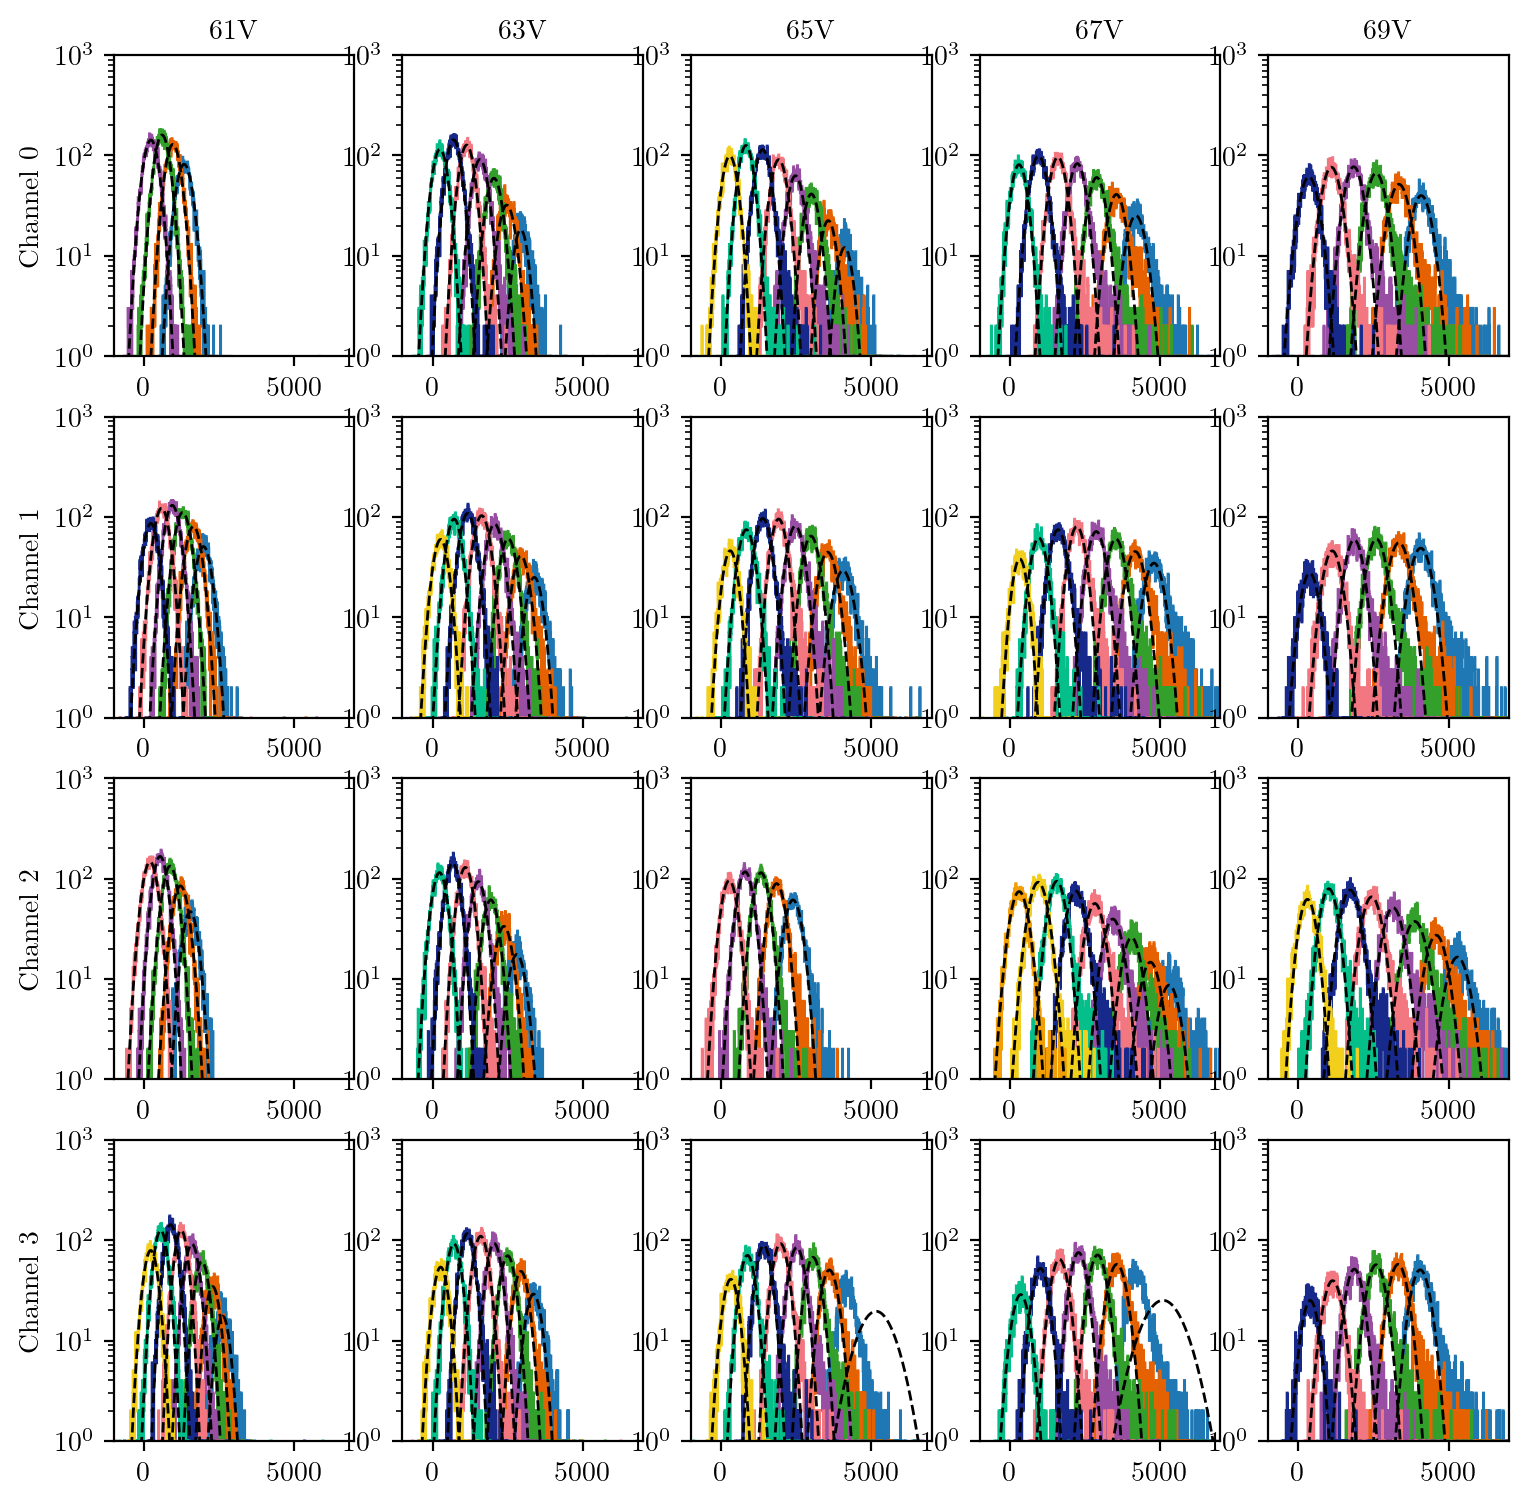

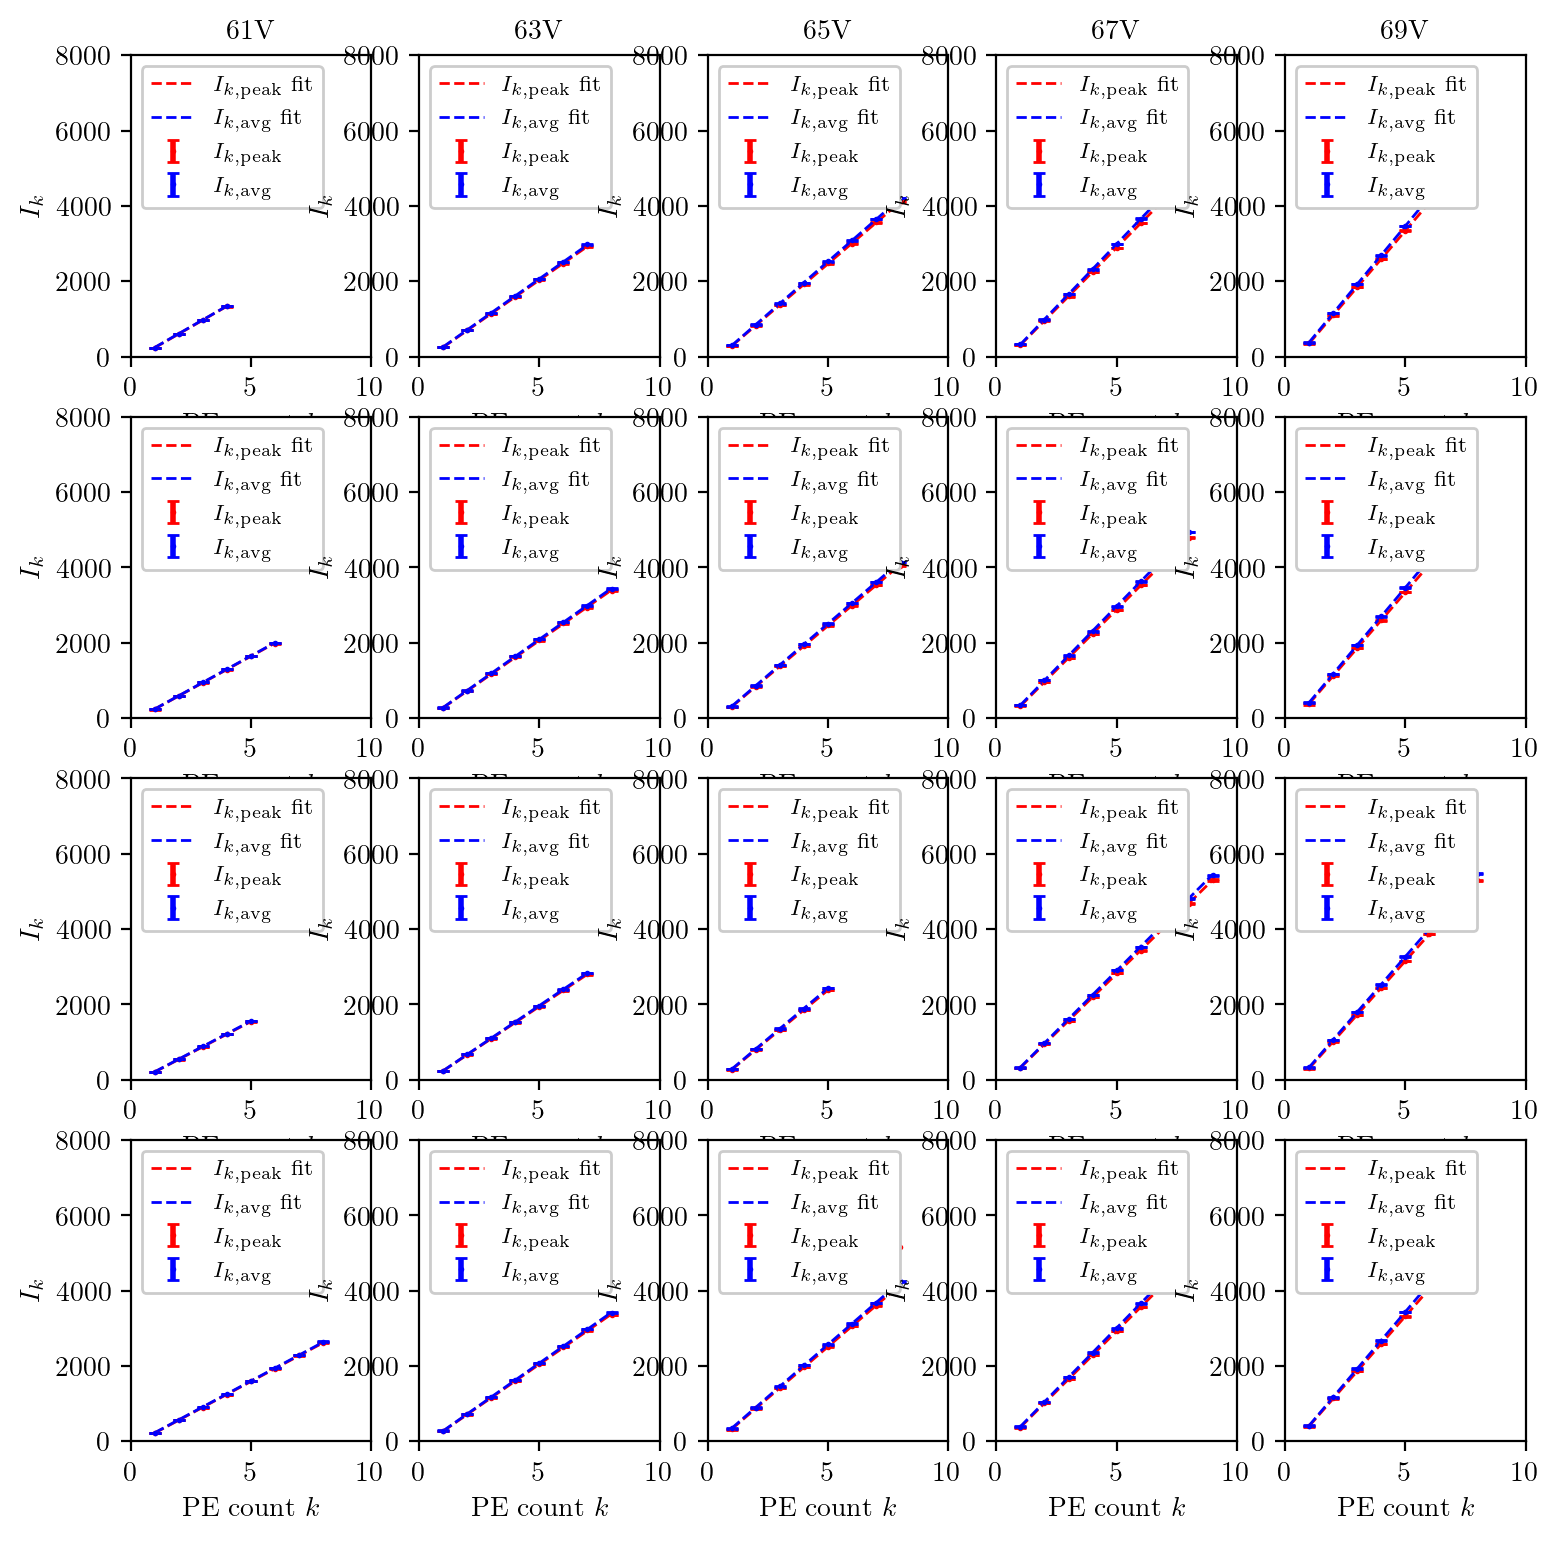

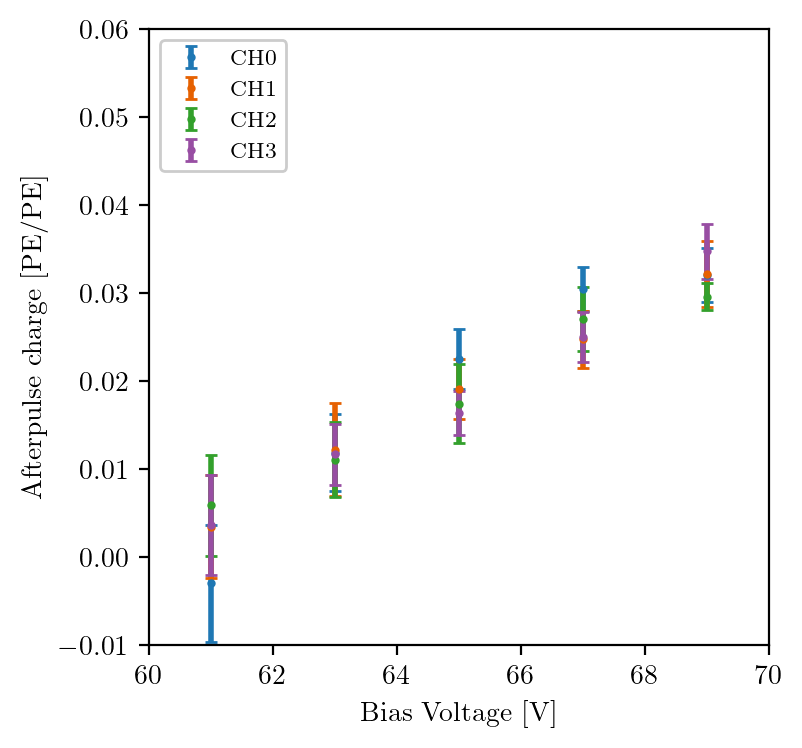

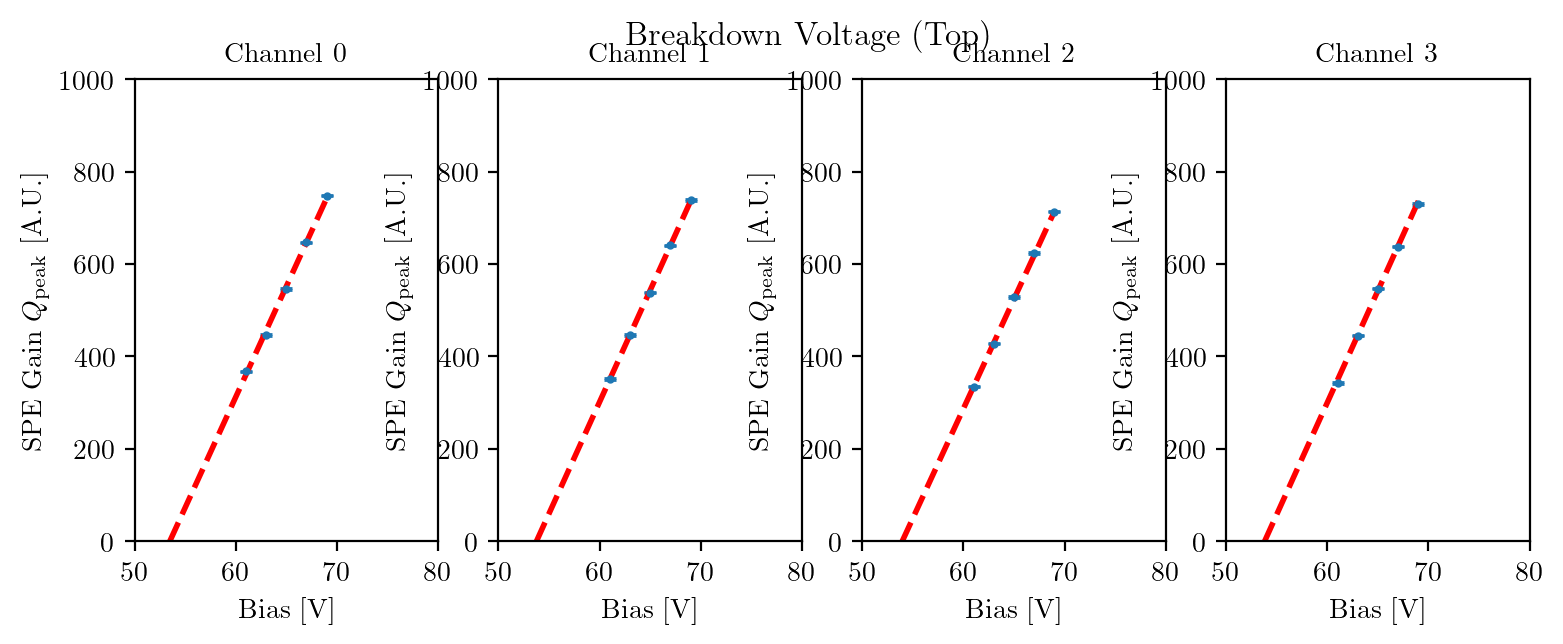

In [8]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_top = np.zeros((4,2))
x_min=-1000
x_max=7000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in range(4):
    for i,data in enumerate(datasets_top):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=3, bin=[x_min, x_max, n_bins])
        
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            if w>0.3*(p+x_min/bin_width):
                w=40 # something weird happened so I need to do this
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets_top], yerr=[data.ch[ch].ap[1] for data in datasets_top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in datasets_top]
    err = [data.ch[ch].q_peak[1] for data in datasets_top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06)
plt.savefig('plots/sipm/afterpulse_bias_top_1101.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_charge_top_1101.pdf')

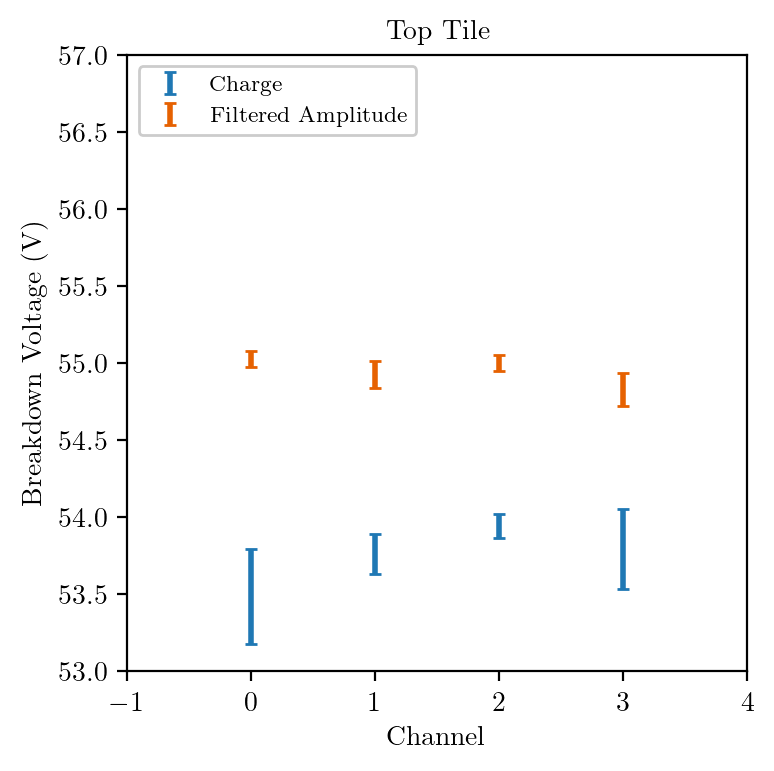

<Figure size 800x600 with 0 Axes>

In [9]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_top[:,0], yerr=Vbd_charge_top[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_top[:,0], yerr=Vbd_famp_top[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Top Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_top_1101.pdf')

## SPE average waveform
Take waveforms with prompt filtered amplitude $|A-A_k|<2\sigma_k$ for $k=1$ and take average.<br>
At $k=1$ PE, afterpulses can be ignored.<br>
The average waveform is fitted by
$$h(t,t') = A_1 e^{-(t-t')/\tau_1} + A_2 e^{-(t-t')/\tau2}$$

# Try to include time jitter
SiPM pulse (single component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$

CH0 61V  A1=3.072+/-0.027 TAU1=0.2952+/-0.0025us A2=2.185+/-0.095 TAU2=0.0270+/-0.0017us sigma=0.0073+/-0.0002us t0=6.327+/-0.000us
CH0 63V  A1=3.754+/-0.027 TAU1=0.2704+/-0.0019us A2=3.061+/-0.118 TAU2=0.0232+/-0.0012us sigma=0.0076+/-0.0002us t0=6.327+/-0.000us
CH0 65V  A1=4.785+/-0.028 TAU1=0.2447+/-0.0015us A2=4.074+/-0.166 TAU2=0.0196+/-0.0010us sigma=0.0079+/-0.0001us t0=6.328+/-0.000us
CH0 67V  A1=5.922+/-0.040 TAU1=0.2219+/-0.0014us A2=5.372+/-0.196 TAU2=0.0200+/-0.0009us sigma=0.0080+/-0.0001us t0=6.328+/-0.000us
CH0 69V  A1=7.732+/-0.049 TAU1=0.2014+/-0.0013us A2=5.395+/-0.331 TAU2=0.0170+/-0.0012us sigma=0.0080+/-0.0002us t0=6.328+/-0.000us
CH1 61V  A1=0.936+/-0.033 TAU1=0.6518+/-0.0183us A2=3.109+/-0.036 TAU2=0.1003+/-0.0024us sigma=0.0057+/-0.0002us t0=6.325+/-0.000us
CH1 63V  A1=1.174+/-0.040 TAU1=0.5888+/-0.0154us A2=4.142+/-0.041 TAU2=0.0969+/-0.0020us sigma=0.0060+/-0.0002us t0=6.326+/-0.000us
CH1 65V  A1=1.589+/-0.053 TAU1=0.4949+/-0.0123us A2=4.950+/-0.052 TAU2=0.087

/home/as111/sipm-analysis/sipm/sipm.py:26: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/sipm.py:26: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


CH3 69V  A1=7.829+/-0.050 TAU1=0.2447+/-0.0018us A2=5.484+/-1.075 TAU2=0.0107+/-0.0018us sigma=0.0075+/-0.0003us t0=6.328+/-0.000us


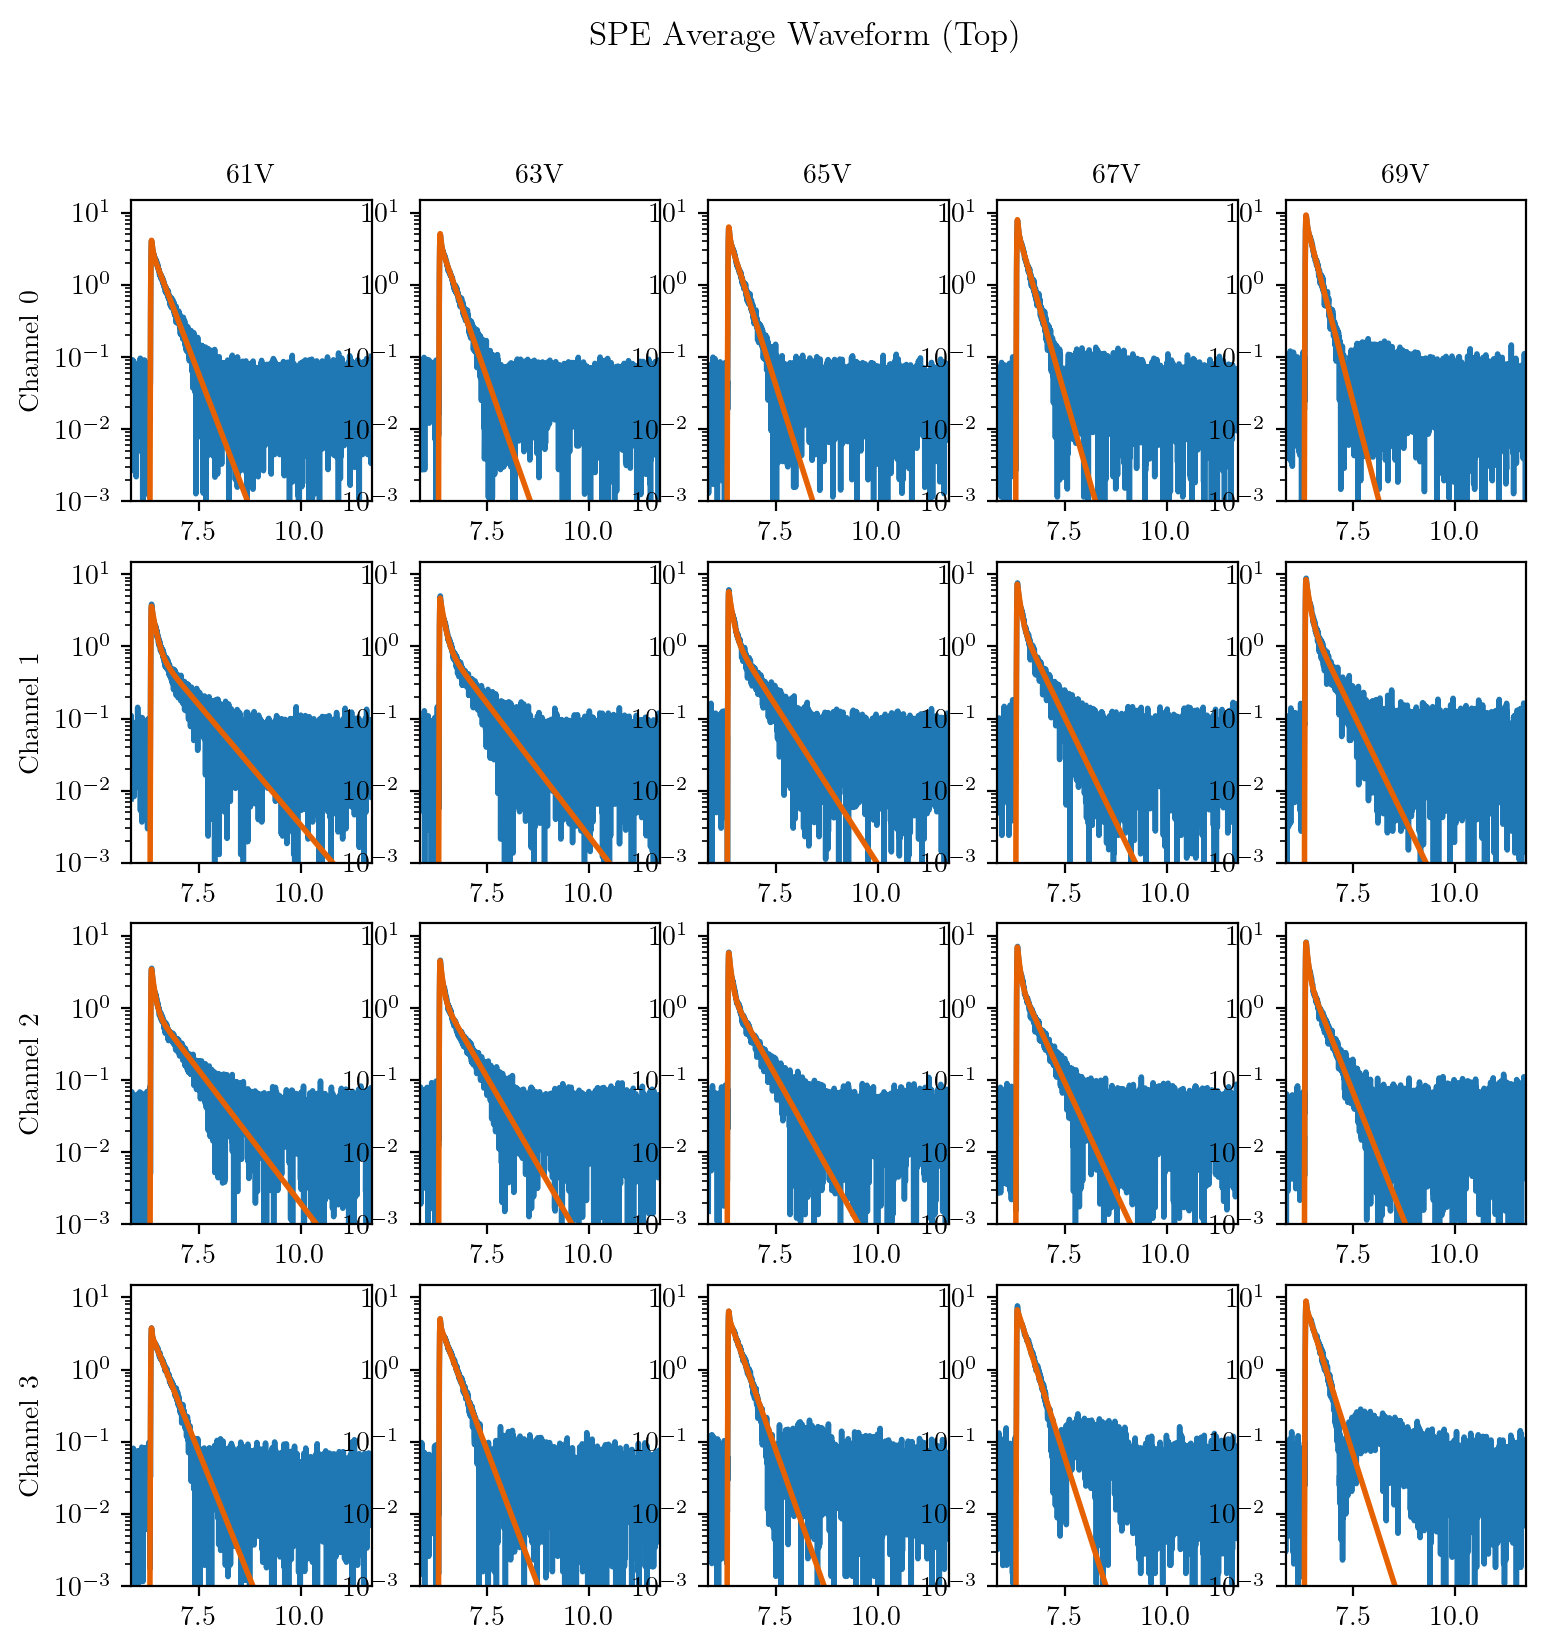

In [10]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for ch in range(4):
    spe_integral = []
    for i,data in enumerate(datasets_top):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        t_end = int(data.ch[ch].trigger_position + 5/data.ch[ch].sample_step)
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[4.8,0.25,4.0,0.02,0.008,6.33], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Top)')
plt.savefig('plots/sipm/spewf_top_1101.pdf')

In [19]:
ch=0
dset = datasets_top[2].ch[ch]
plt.plot(dset.time, dset.spe_avgwf, label='Data', linewidth=1)
print(np.std(dset.spe_avgwf[:dset.baseline_samples]))
print(dset.baseline_samples*dset.sample_step, np.mean(dset.spe_avgwf[:dset.baseline_samples]), np.median(dset.spe_avgwf[:dset.baseline_samples]))
print(np.mean(dset.spe_avgwf[int(12/dset.sample_step):]), np.median(dset.spe_avgwf[int(12/dset.sample_step):]))
plt.plot(dset.time, dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0074,6.327), label='Fit', linewidth=1)
# plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
plt.ylim(-1, 1)
plt.xlim(0,16)
plt.legend(loc='upper right')
# plt.yscale('log')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Count]')
plt.suptitle('SPE Average Waveform (Top Ch{} 65V)'.format(ch))


NameError: name 'datasets_top' is not defined

# Bottome tile calibration (1103 data)

## Directories

In [4]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-03/'
bias = [61, 63, 65, 67, 69]
subdir = ['2022-11-03_volt_{}_pos_bottom_light_laser_coinc_none_cond_calibration/'.format(bias_) for bias_ in bias]

In [5]:
datasets_bot = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=4000)
    for i in range(4):
        data.ch[i].read_data(header=True)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].clear()
    datasets_bot.append(data)

## Plot filtered amplitude histogram and analyze

mu=2.121 p=0.086
mu=2.380 p=0.121
mu=2.559 p=0.168
mu=2.604 p=0.231
mu=2.702 p=0.316
Channel 0 Vbd=55.114+/-0.060V slope=8.972+/-0.051
mu=3.042 p=0.076
mu=3.442 p=0.101
mu=3.653 p=0.177
mu=3.839 p=0.216
mu=4.018 p=0.280
Channel 1 Vbd=54.896+/-0.117V slope=8.540+/-0.108
mu=3.083 p=0.073
mu=3.449 p=0.114
mu=3.667 p=0.159
mu=3.804 p=0.207
mu=3.886 p=0.274
Channel 2 Vbd=55.222+/-0.161V slope=8.102+/-0.125
mu=1.952 p=0.070
mu=2.124 p=0.122
mu=2.304 p=0.161
mu=2.380 p=0.214
mu=2.455 p=0.279
Channel 3 Vbd=55.194+/-0.030V slope=7.400+/-0.021


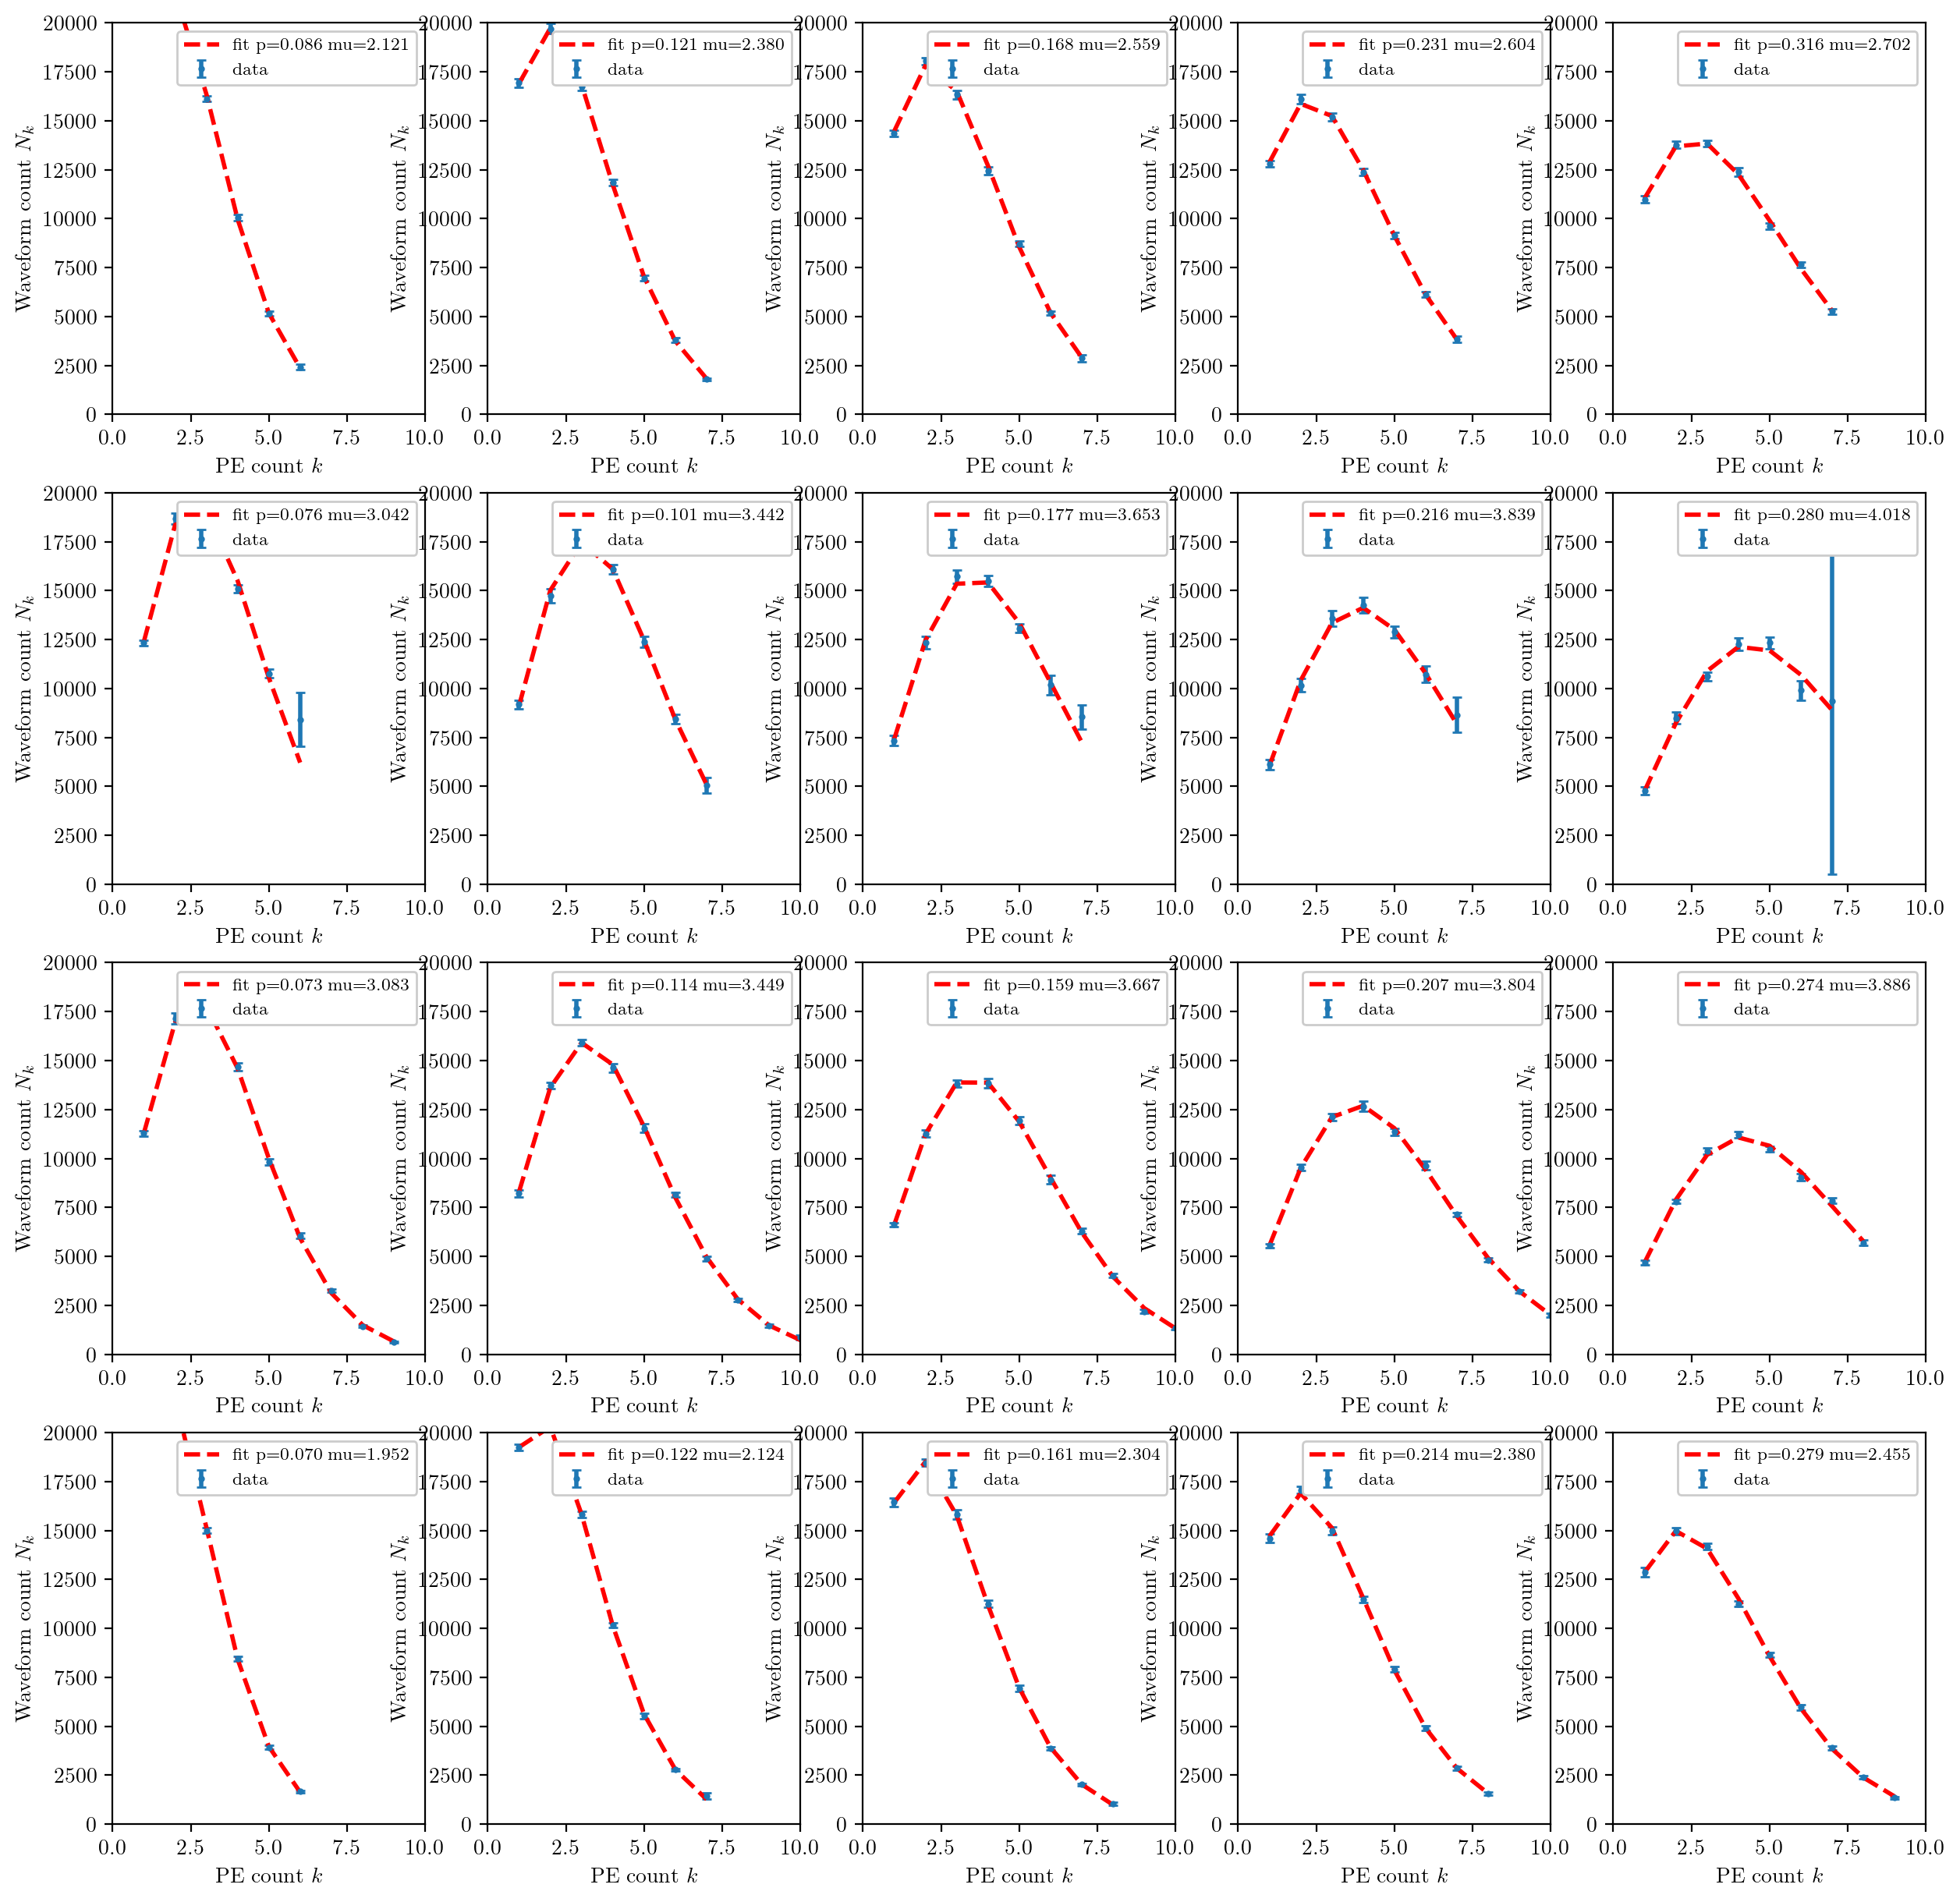

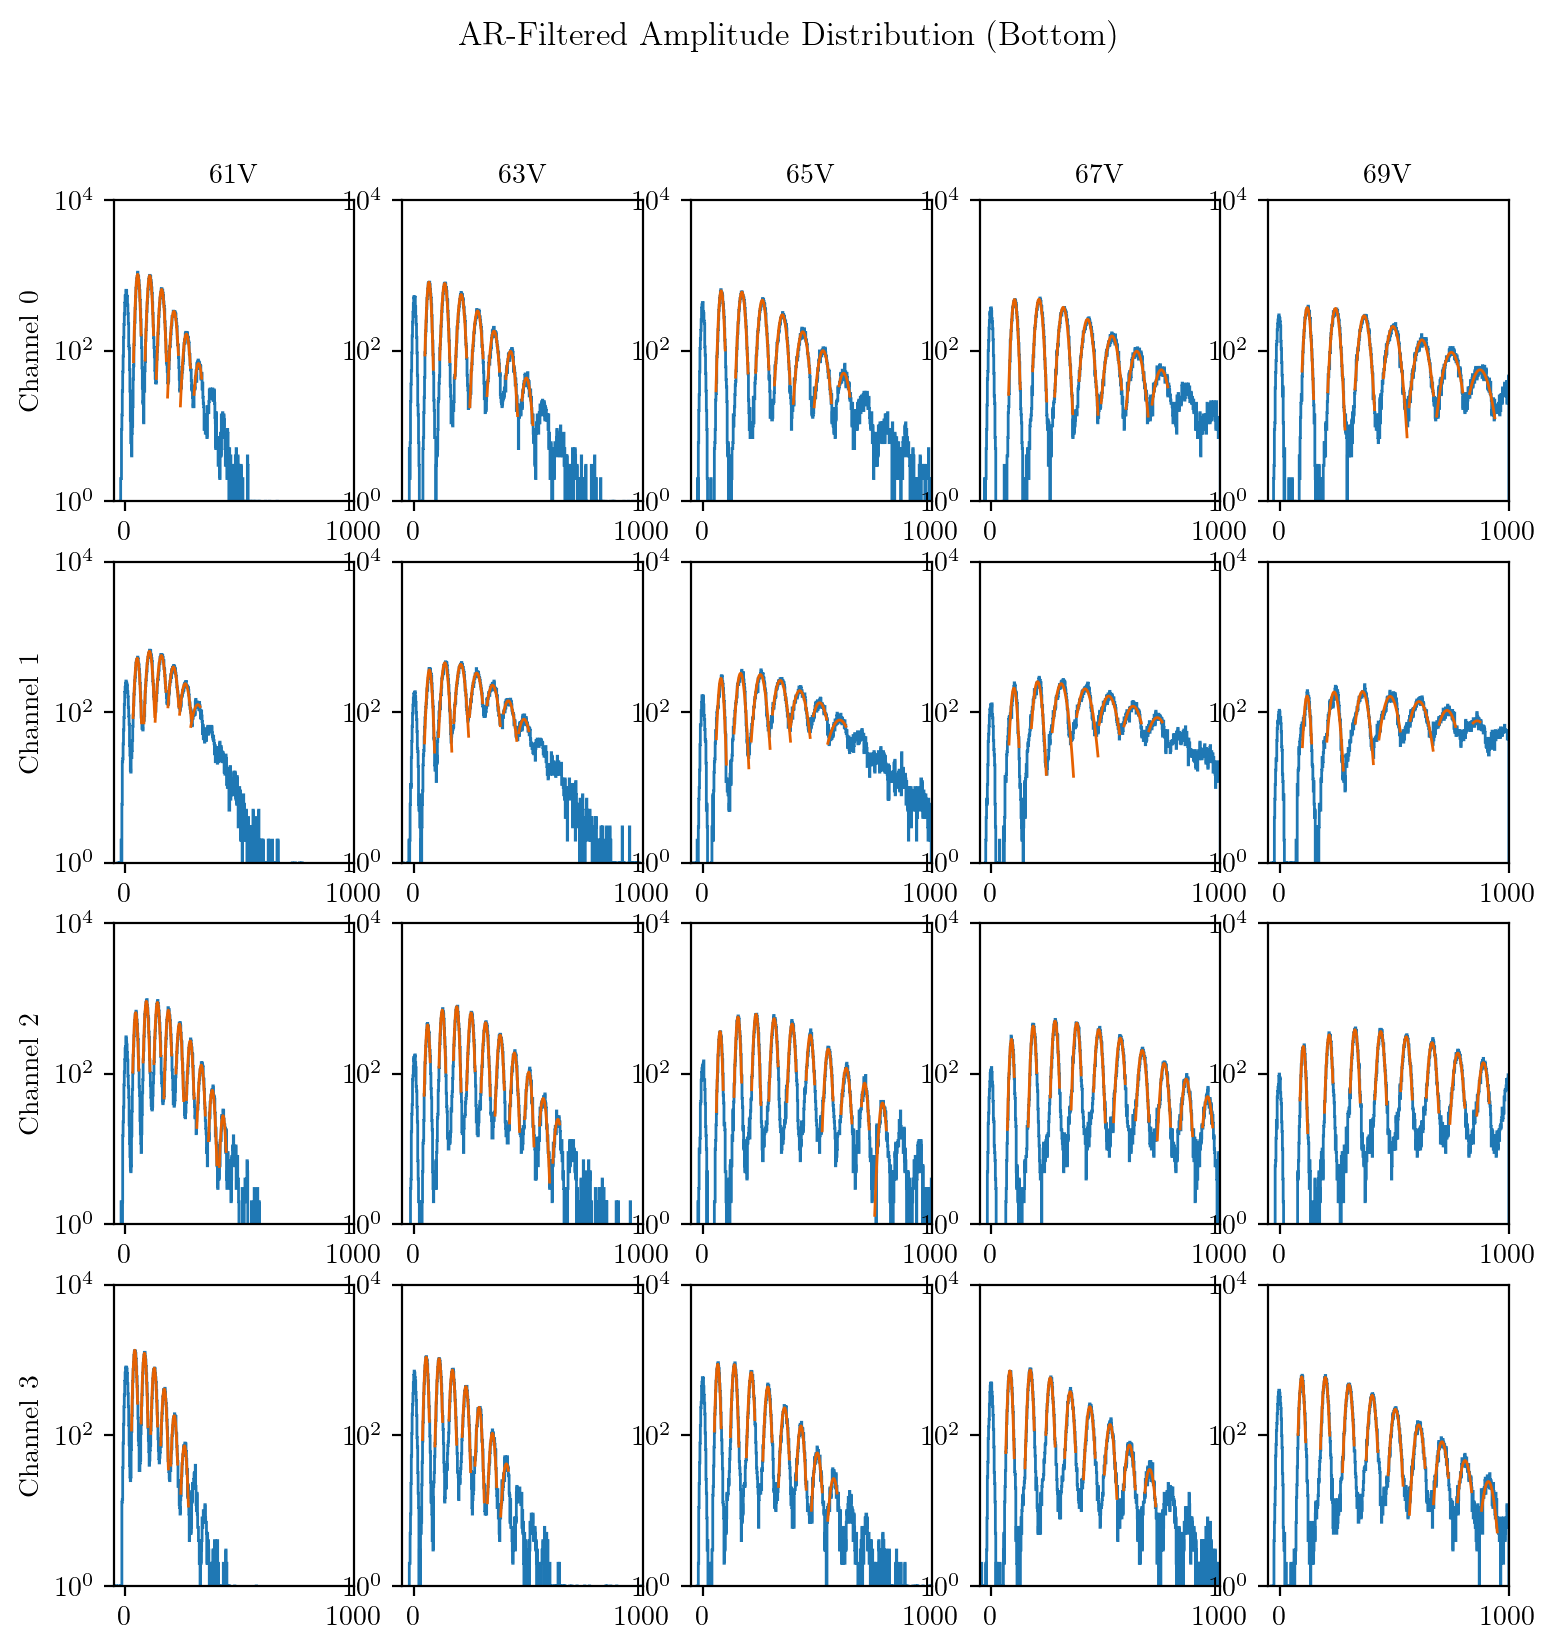

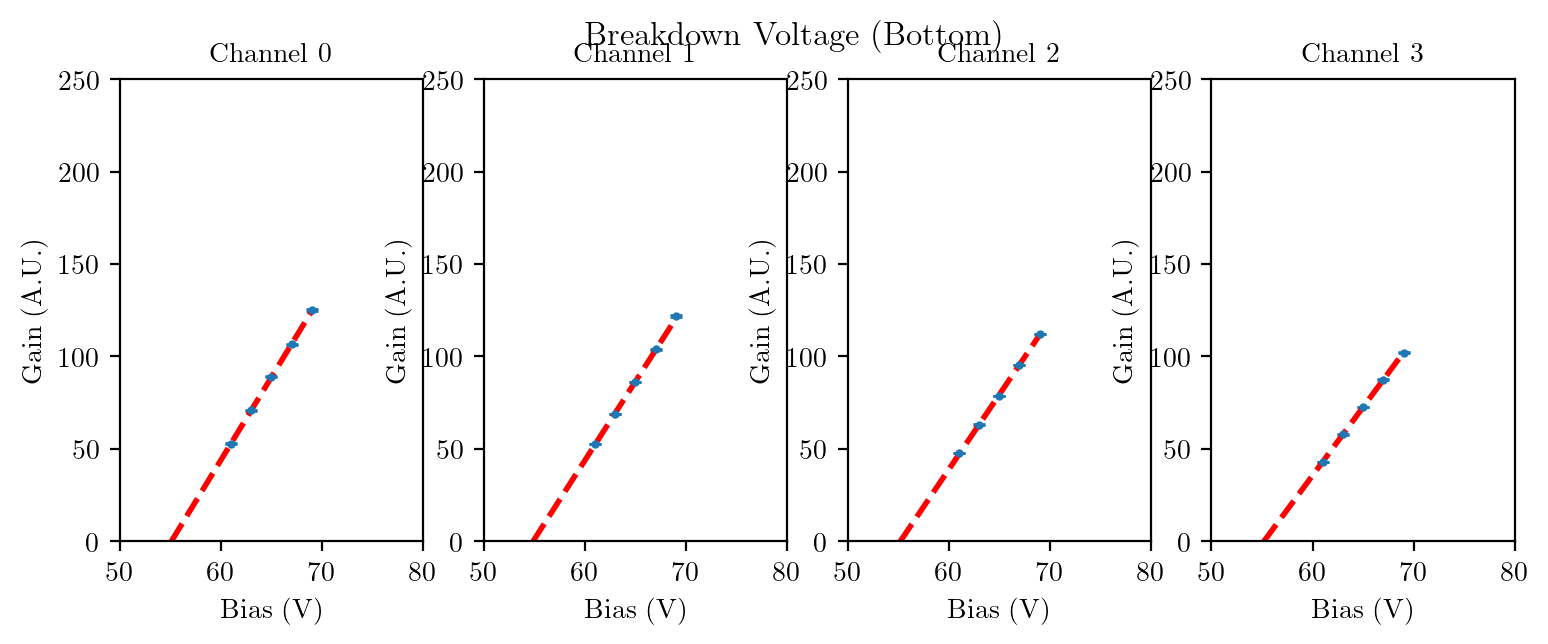

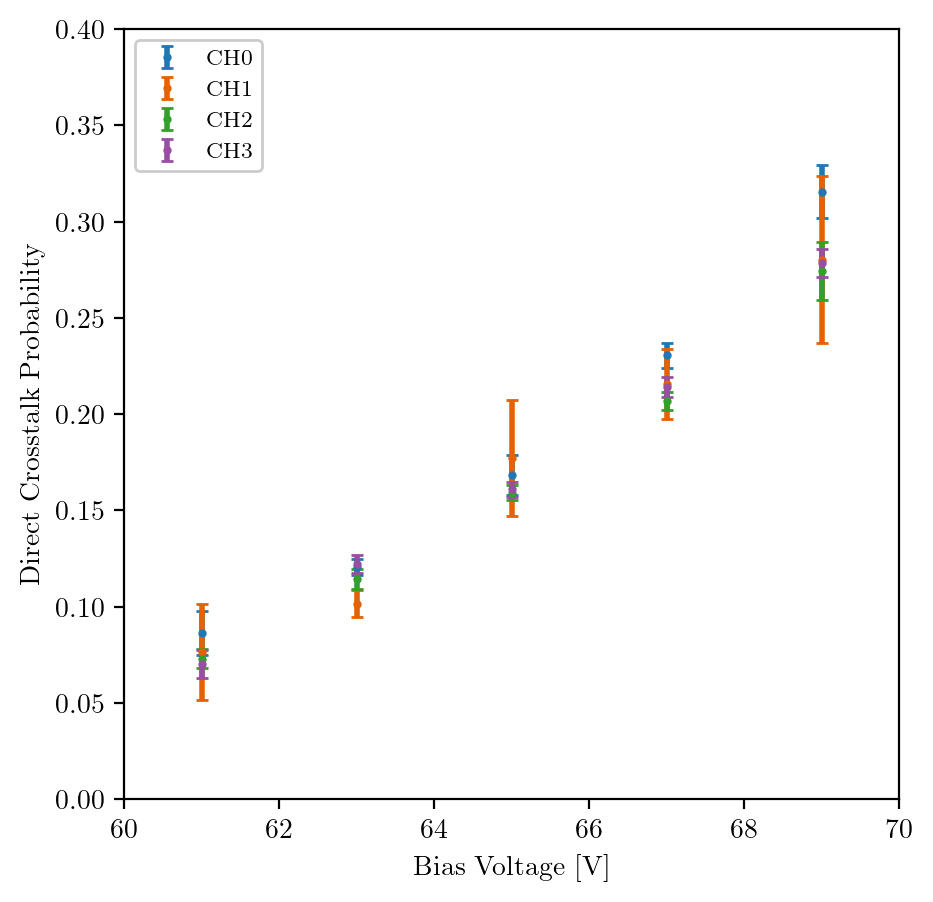

In [7]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_bot = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_bot):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-50,1e3,600])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=40, prom=30, wid=8, dist=8)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].nevents)
        plt.xlim(0,10)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets_bot], yerr=[data.ch[ch].ct[1] for data in datasets_bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in datasets_bot]
    err = [data.ch[ch].q_a[1] for data in datasets_bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
plt.savefig('plots/sipm/famp_histo_bot_1101.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_famp_bot_1101.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4)
plt.savefig('plots/sipm/dict_bot_1101.pdf')

## Afterpulsing


Channel 0 Vbd=54.013+/-0.337V slope=49.921+/-1.352
Channel 1 Vbd=53.548+/-0.173V slope=46.670+/-0.763


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Channel 2 Vbd=53.827+/-0.260V slope=47.152+/-1.064
Channel 3 Vbd=54.569+/-0.139V slope=45.435+/-0.575


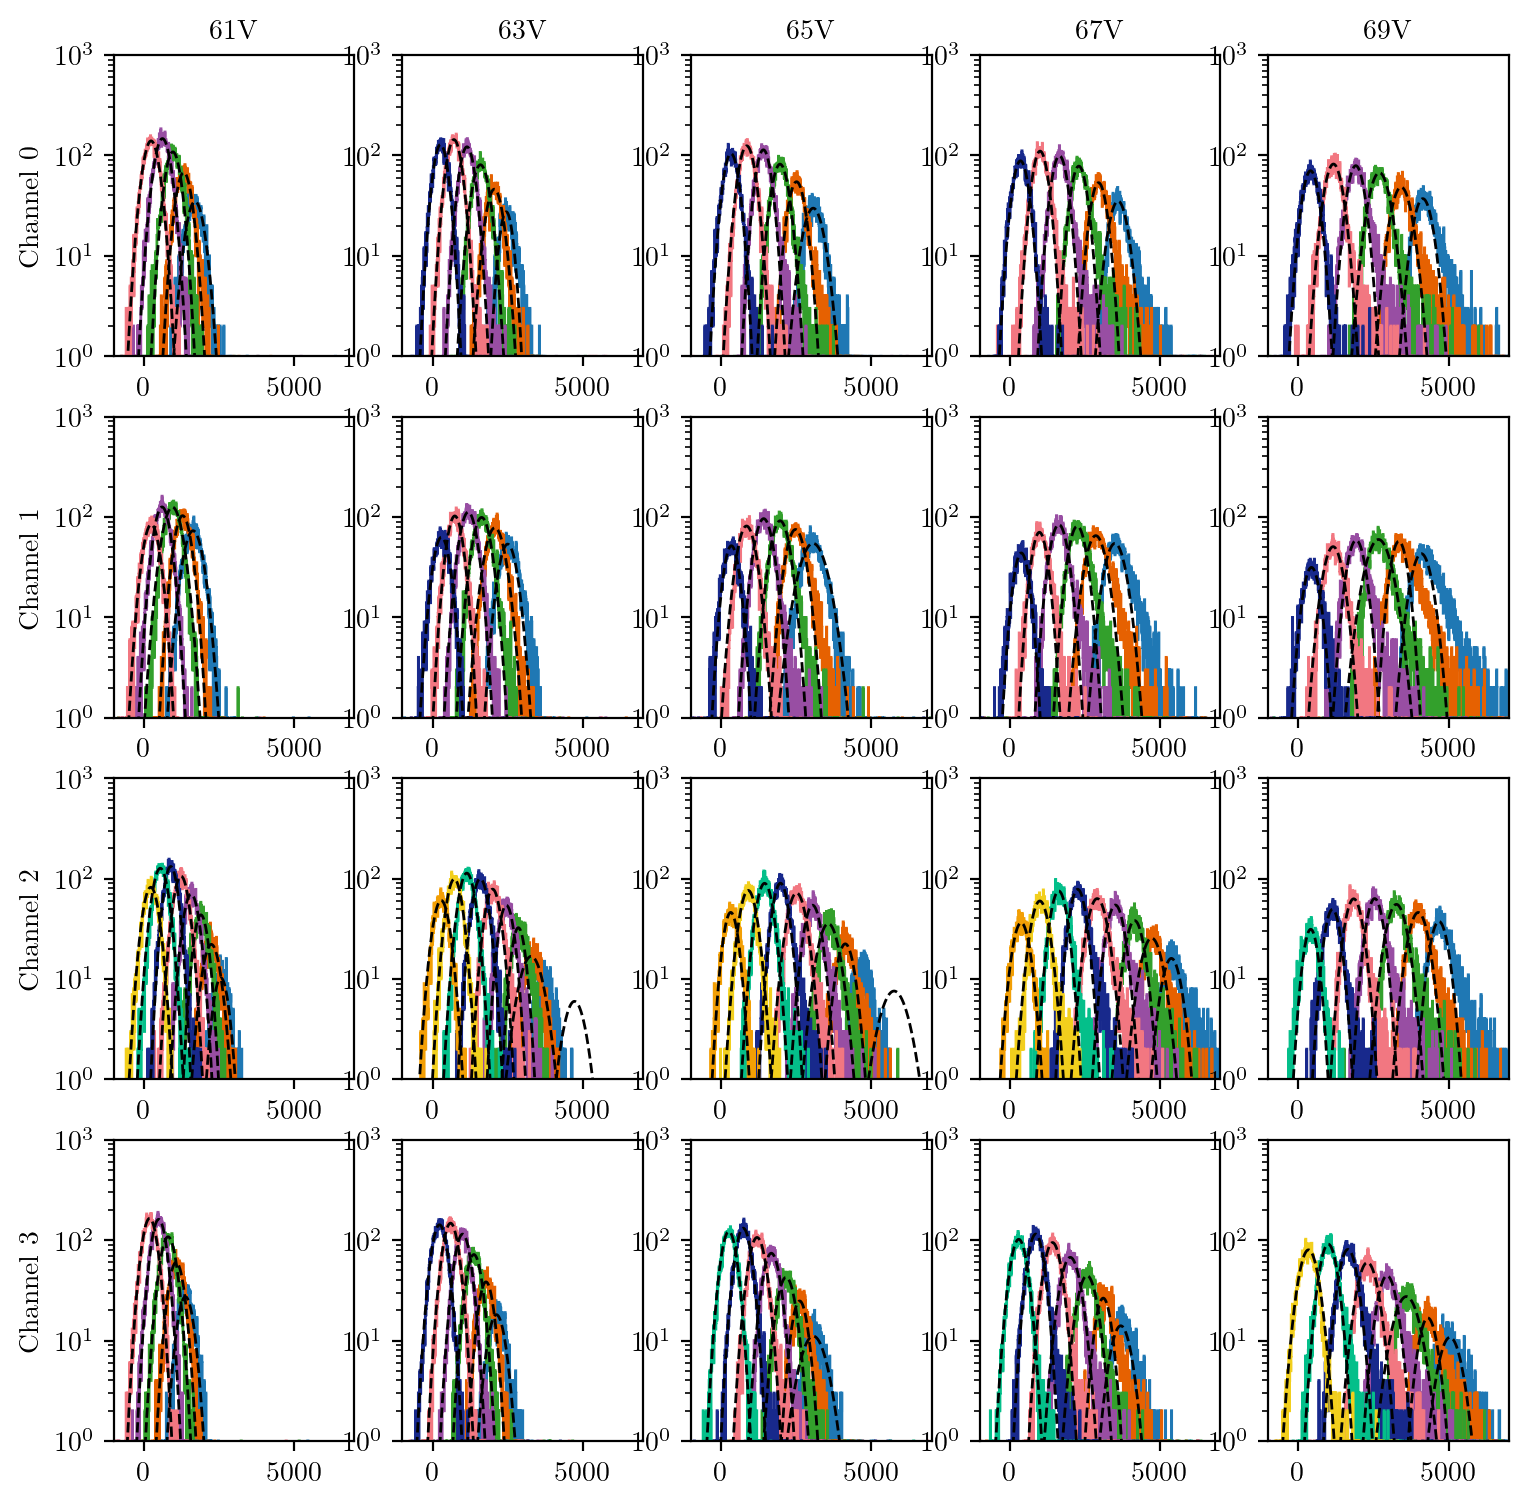

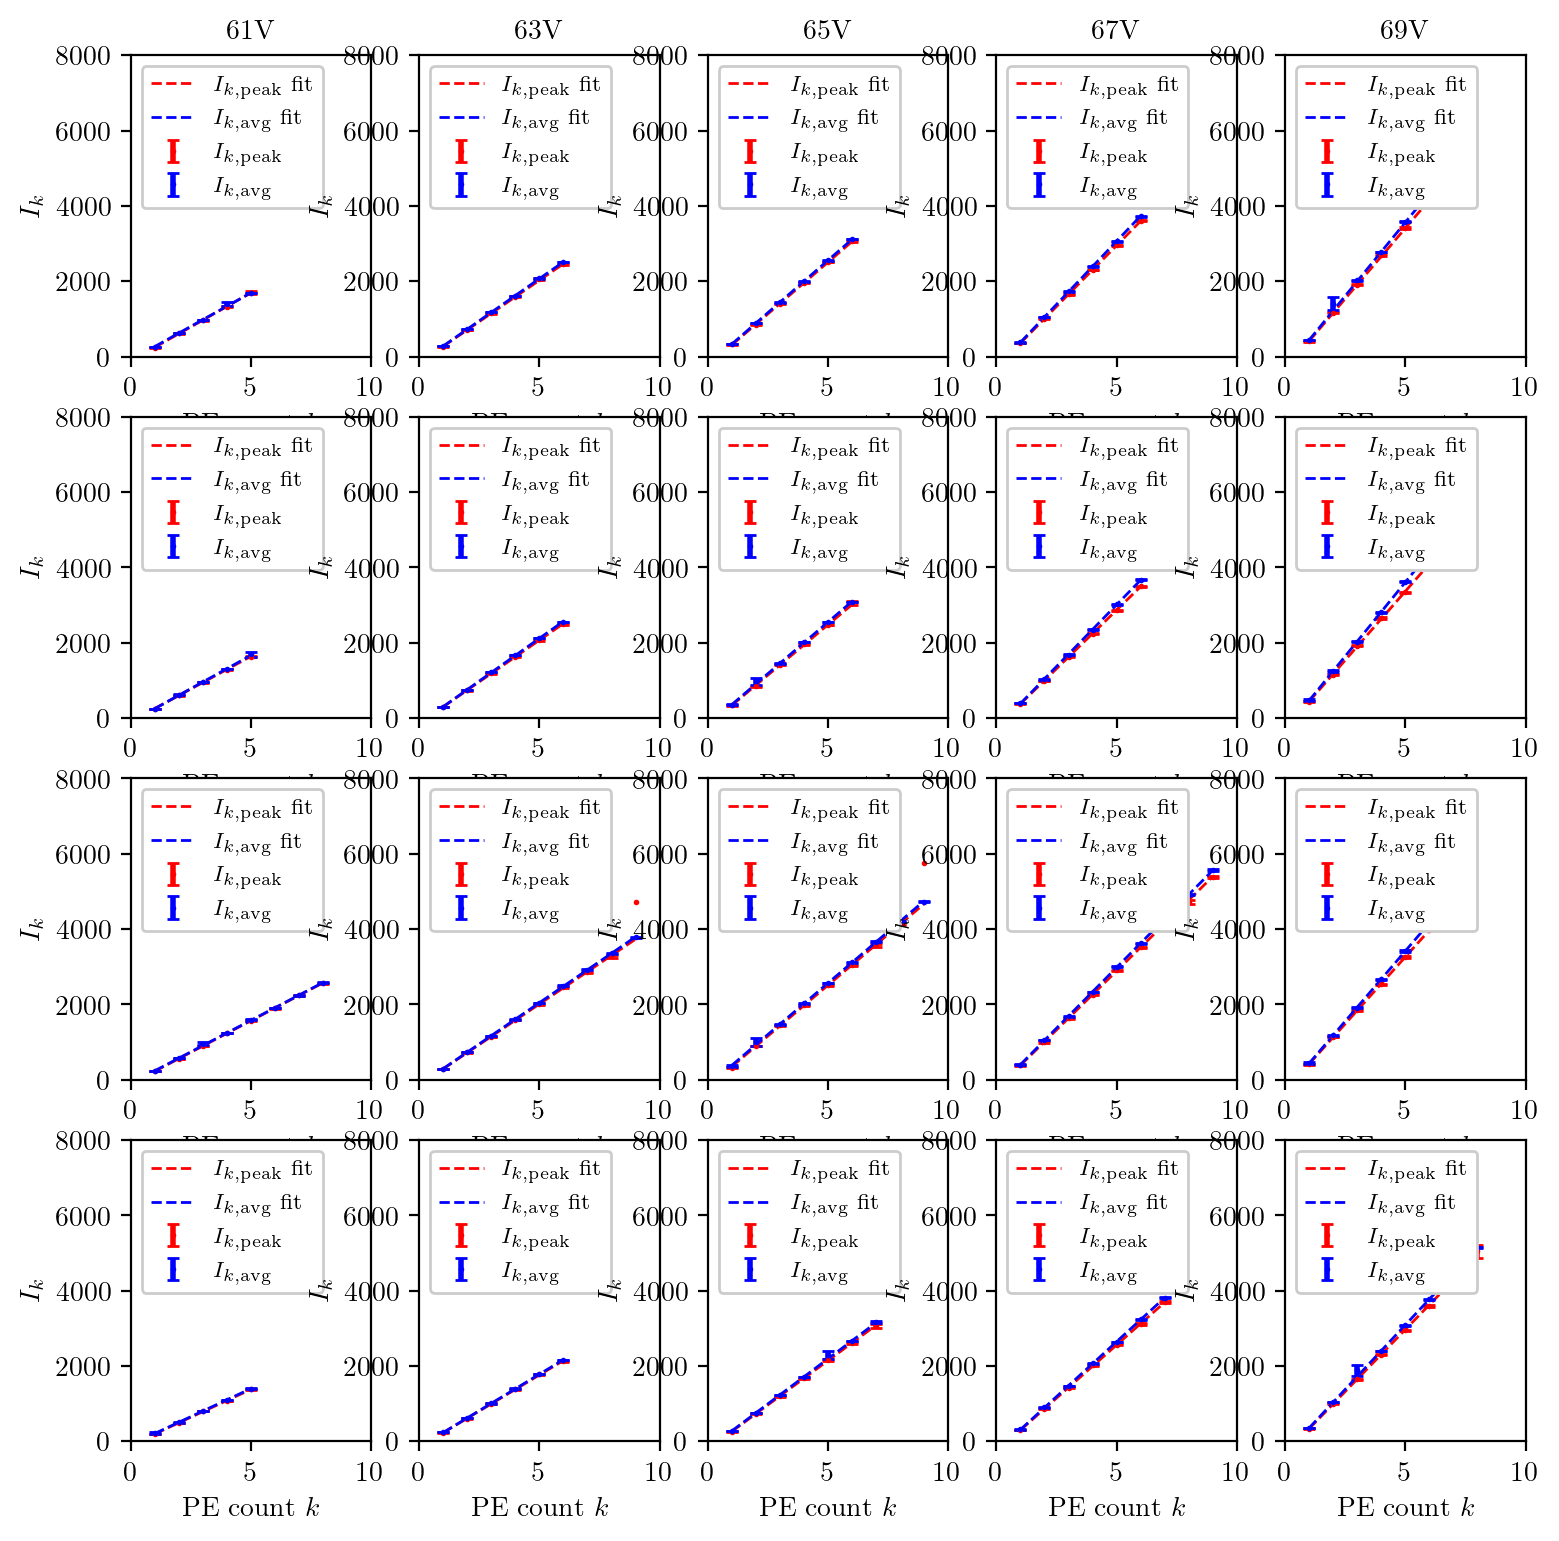

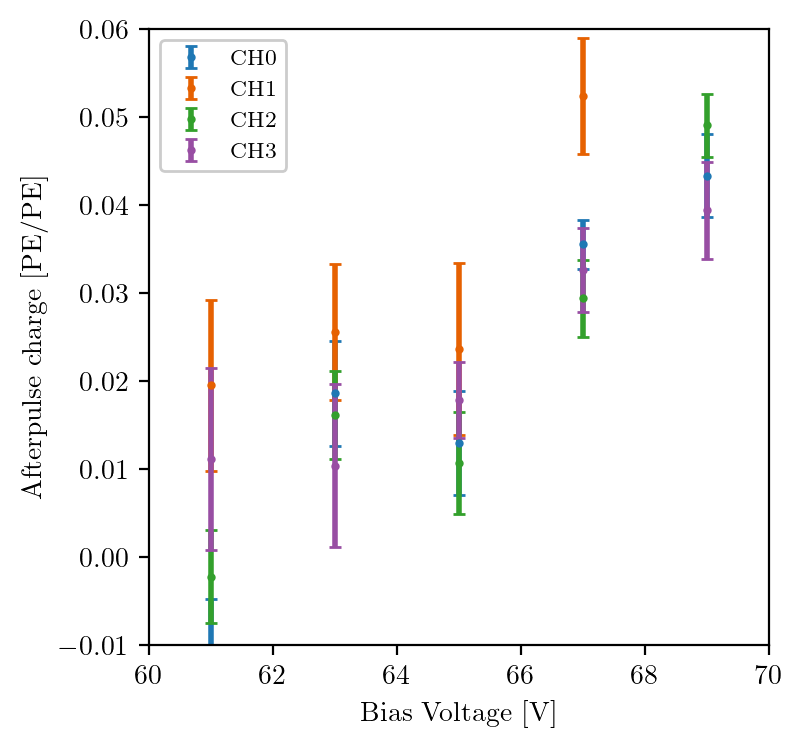

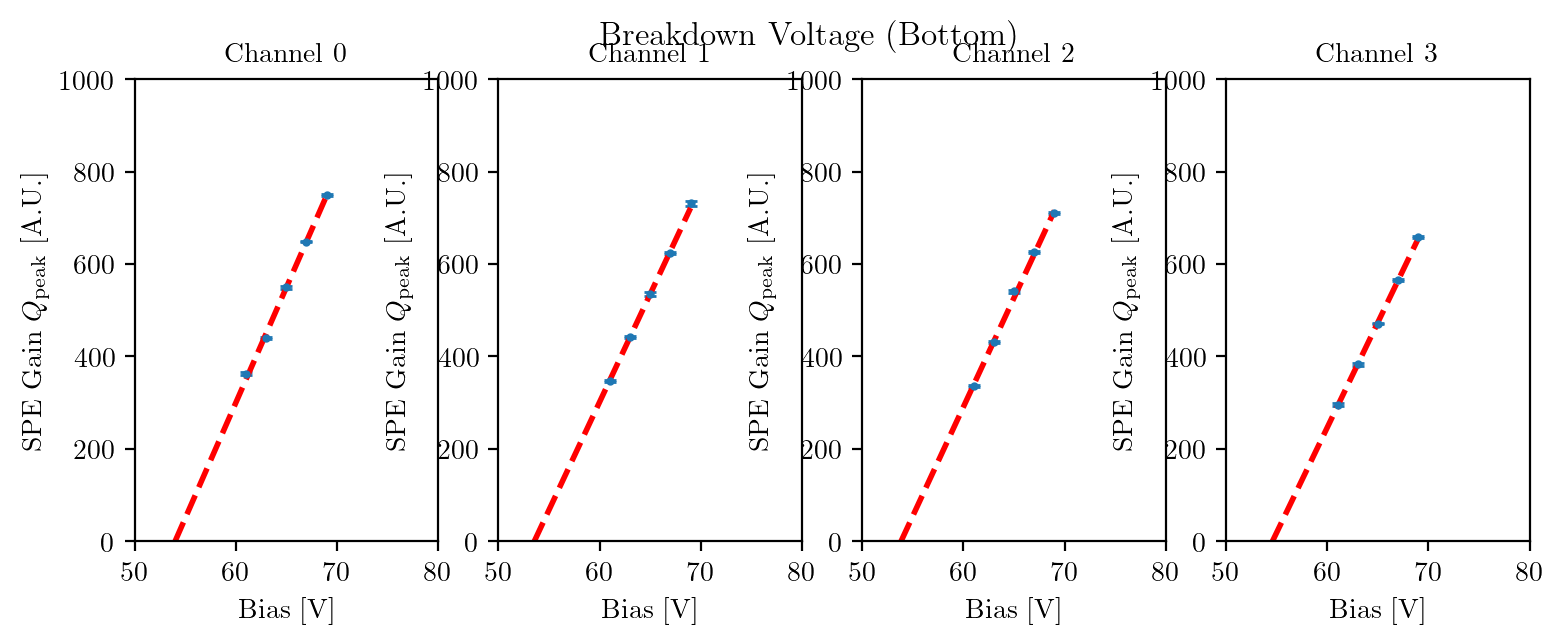

In [8]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_bot = np.zeros((4,2))
x_min=-1000
x_max=7000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in range(4):
    for i,data in enumerate(datasets_bot):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=2, bin=[x_min, x_max, n_bins])
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            if w>0.1*(p+x_min/bin_width):
                w=30 # something weird happened so I need to do this
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets_bot], yerr=[data.ch[ch].ap[1] for data in datasets_bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in datasets_bot]
    err = [data.ch[ch].q_peak[1] for data in datasets_bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06)
plt.savefig('plots/sipm/afterpulse_bias_bot_1101.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_charge_bot_1101.pdf')

# Breakdown voltage summary

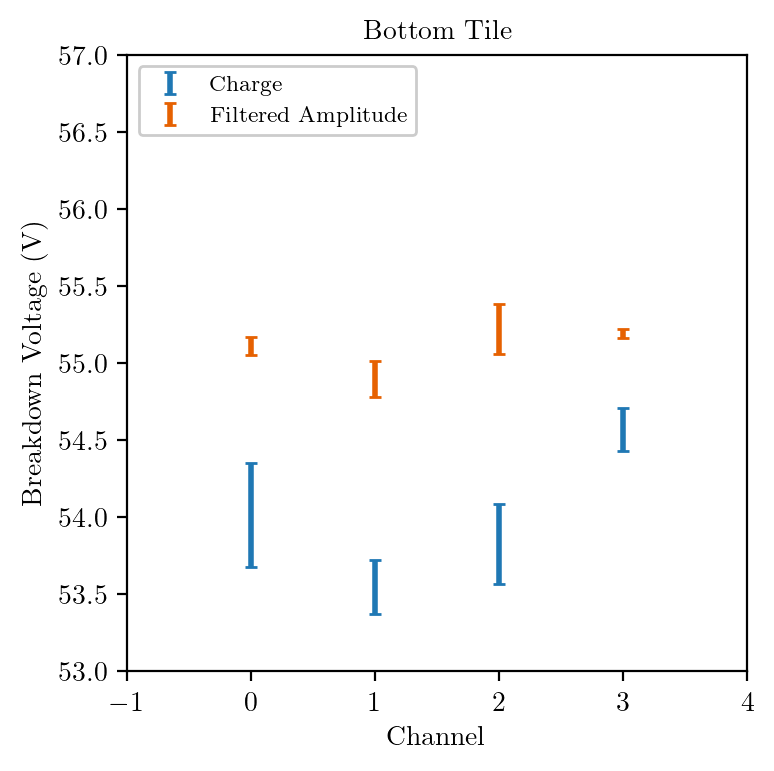

<Figure size 800x600 with 0 Axes>

In [9]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_bot[:,0], yerr=Vbd_charge_bot[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_bot[:,0], yerr=Vbd_famp_bot[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Bottom Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_bot_1101.pdf')

## SPE average waveform

CH0 61V  A1=2.085+/-0.019 TAU1=0.4174+/-0.0040us A2=8.362+/-0.169 TAU2=0.0204+/-0.0006us sigma=0.0106+/-0.0002us t1=6.365+/-0.001us, t2=6.332+/-0.000us
CH0 63V  A1=2.550+/-0.021 TAU1=0.3838+/-0.0034us A2=10.292+/-0.185 TAU2=0.0195+/-0.0005us sigma=0.0101+/-0.0002us t1=6.361+/-0.001us, t2=6.331+/-0.000us
CH0 65V  A1=3.249+/-0.023 TAU1=0.3634+/-0.0027us A2=13.334+/-0.230 TAU2=0.0177+/-0.0004us sigma=0.0100+/-0.0002us t1=6.359+/-0.001us, t2=6.332+/-0.000us
CH0 67V  A1=3.855+/-0.039 TAU1=0.3660+/-0.0033us A2=6.072+/-0.100 TAU2=0.0431+/-0.0011us sigma=0.0053+/-0.0003us t1=6.334+/-0.000us, t2=6.324+/-0.000us
CH0 69V  A1=5.006+/-0.054 TAU1=0.3390+/-0.0031us A2=6.099+/-0.115 TAU2=0.0442+/-0.0014us sigma=0.0054+/-0.0004us t1=6.333+/-0.000us, t2=6.323+/-0.000us
CH1 61V  A1=0.486+/-0.009 TAU1=1.0776+/-0.0221us A2=4.370+/-0.025 TAU2=0.1031+/-0.0011us sigma=0.0071+/-0.0002us t1=6.430+/-0.001us, t2=6.327+/-0.000us
CH1 63V  A1=0.634+/-0.010 TAU1=0.9702+/-0.0162us A2=5.848+/-0.027 TAU2=0.0983+/-0.0008

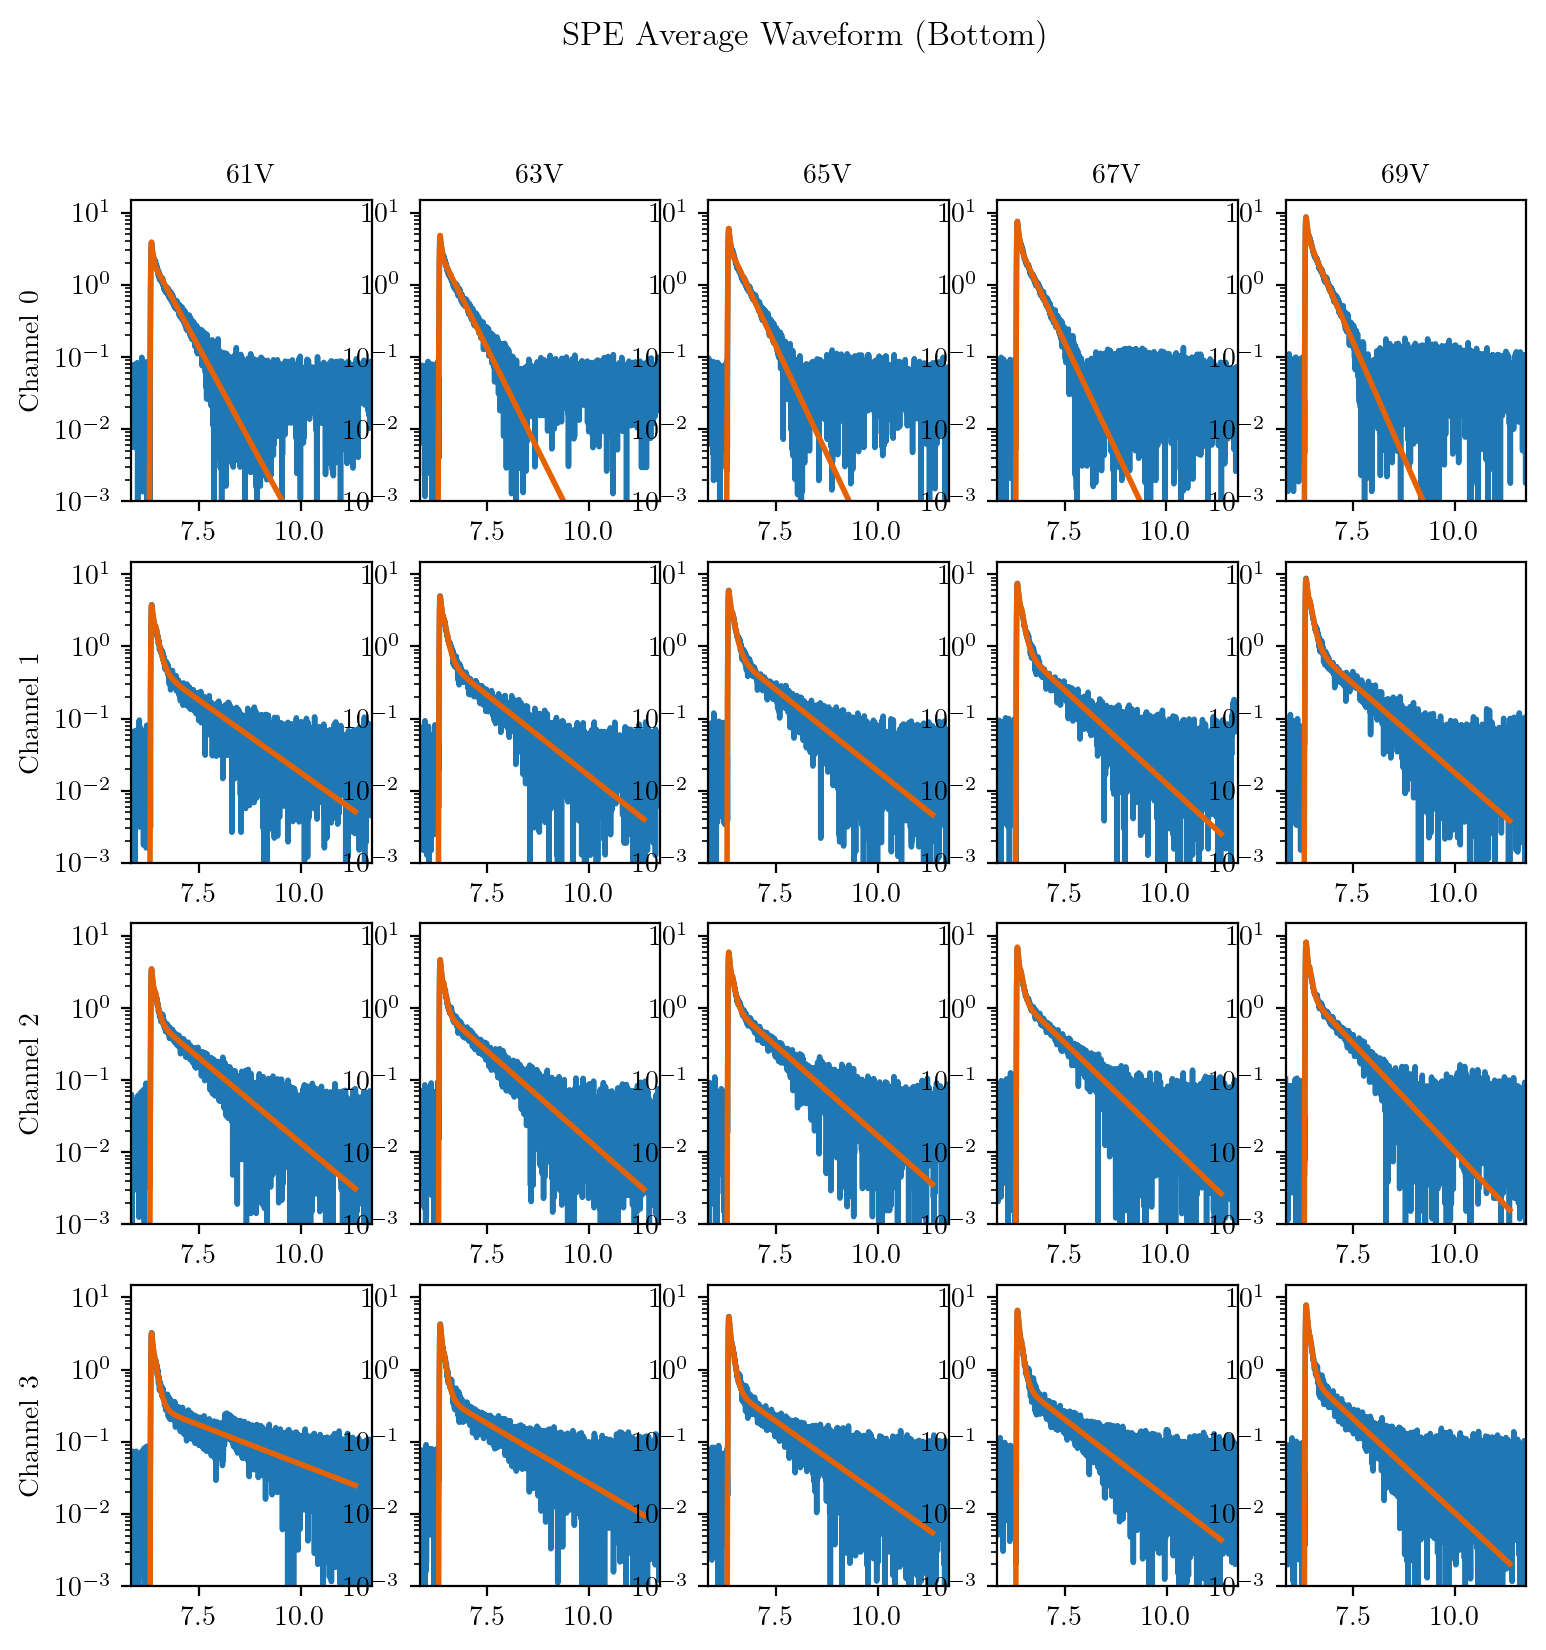

In [15]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for ch in range(4):
    spe_integral = []
    for i,data in enumerate(datasets_bot):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        data.ch[ch].spe_avgwf -= np.array([np.mean(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])]*data.ch[ch].samples)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        t_end = int(data.ch[ch].trigger_position + 5/data.ch[ch].sample_step)
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[5,1,6,0.1,0.005,6.45,6.30], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t1={:.3f}+/-{:.3f}us, t2={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5]),popt[6],np.sqrt(pcov[6,6])))
        data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
plt.savefig('plots/sipm/spewf_bot_1101.pdf')

In [48]:
import csv
for i,v in enumerate(bias):
    with open('../pulse_parameters_{}V.csv'.format(v), 'w') as f:
        w = csv.writer(f)
        w.writerow(['CH', 'A1 [ADC count]', 'tau1 [us]', 'A2 [ADC count]', 'tau2 [us]'])
        for ch in range(4):
            w.writerow(['T{}'.format(ch)]+[str(par) for par in np.array(datasets_top[i].ch[ch].get_pulse_pars())[:]])
        for ch in range(4):
            w.writerow(['B{}'.format(ch)]+[str(par) for par in np.array(datasets_bot[i].ch[ch].get_pulse_pars())[:]])

In [60]:
ch=2
dset = datasets_bot[2].ch[ch]

print(np.std(dset.spe_avgwf[:dset.baseline_samples]))
print(dset.baseline_samples*dset.sample_step, np.mean(dset.spe_avgwf[:dset.baseline_samples]), np.median(dset.spe_avgwf[:dset.baseline_samples]))
print(np.mean(dset.spe_avgwf[int(12/dset.sample_step):]), np.median(dset.spe_avgwf[int(12/dset.sample_step):]))

plt.figure(0)
plt.plot(dset.time, dset.spe_avgwf, label='Data', linewidth=1)
plt.plot(dset.time, dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0073,6.423,6.326), label='Fit', linewidth=1)
residual = dset.spe_avgwf-dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0073,6.423,6.326)
plt.ylim(-1, 8)
plt.xlim(5,12)
plt.legend(loc='upper right')
# plt.yscale('log')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Count]')
plt.suptitle('SPE Average Waveform (Bottom Ch{} 65V)'.format(ch))

plt.figure(1)
plt.plot(dset.time, residual, linewidth=1)
plt.ylim(-1, 1)
plt.xlim(5,12)
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Residual [ADC Count]')

NameError: name 'datasets_bot' is not defined

# Try FFT-based deconvolution
- $\tilde{f}(\omega)$: average waveform FFT
- $\tilde{g}(\omega)$: start time distribution FFT
- $\tilde{h}(\omega)$: SiPM pulse FFT
$$\tilde{g}(\omega) \propto \frac{\tilde{f}(\omega)}{\tilde{h}(\omega)}$$

In [20]:
from scipy.fft import fft, ifft
dset = datasets_bot[2].ch[0]
ftilde = fft(dset.spe_avgwf)
a1,tau1,a2,tau2 = dset.get_pulse_pars()
h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
htilde = fft(h(dset.time))

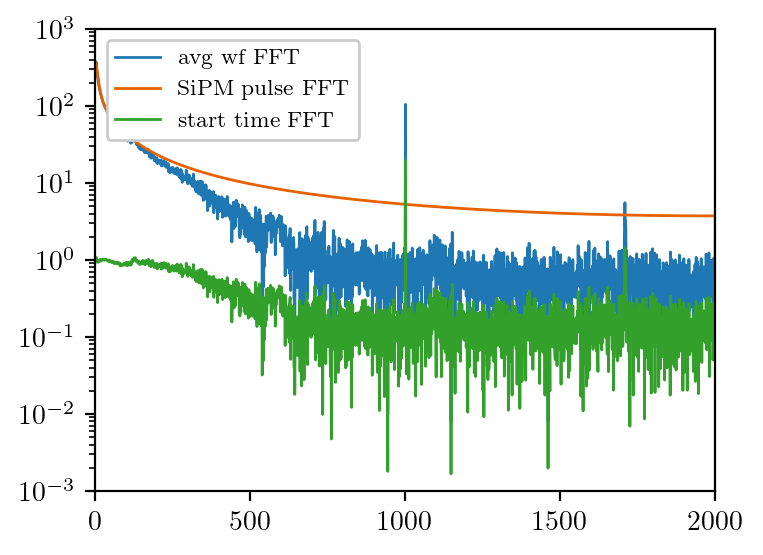

In [21]:
plt.plot(abs(ftilde), label='avg wf FFT', linewidth=1)
plt.plot(abs(htilde), label='SiPM pulse FFT', linewidth=1)
plt.plot(abs(ftilde/htilde), label='start time FFT', linewidth=1)
plt.legend()
plt.xlim(0,2000)
plt.yscale('log')

/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.9400054783777446


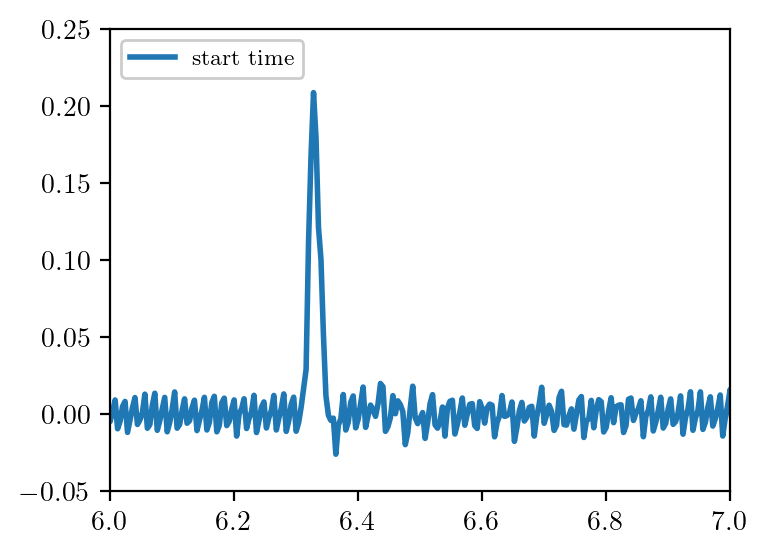

In [22]:
plt.plot(dset.time, ifft(ftilde/htilde), label='start time')
plt.legend()
plt.xlim(6,7)
print(abs(np.sum((ifft(ftilde/htilde)))))

# High stat calibration data (11/15 top 65V)

In [4]:
dir1115top = ['/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_laser_coinc_laser_cond_calibration/','/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-15/2022-11-15_volt_65_pos_top_light_laser_coinc_111_cond_calibration/']

In [5]:
ds1115top = [] #[laser trigger, coinc trigger]
for i,dir in enumerate(dir1115top):
    data = ds.Dataset('', pol=-1, channels=range(4), samples=4000, spe=[556.758,548.693,548.862,541.270])
    for j in range(20):
        for ch in range(4):
            data.ch[ch].path = "{}{}/".format(dir, j)
            data.ch[ch].read_data(header=True)
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].ar_filter(tau=20)
            data.ch[ch].get_famp()
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    ds1115top.append(data)

KeyboardInterrupt: 

In [ ]:
plt.figure(0,figsize=(9,3)) # for filtered amplitude histograms
plt.figure(2,figsize=(15,5)) # for Vinogradov fit
for ch in range(4):
    dset = ds1115top[0]
    #filtered amplitude histogram
    dset.ch[ch].get_famp_hist(bin=[-50,1.5e3,1000])
    plt.figure(0)
    plt.subplot(1,4,ch+1)
    plt.suptitle('Channel {}'.format(ch))
    plt.stairs(dset.ch[ch].famp_hist, dset.ch[ch].famp_hist_bin)
    plt.yscale('log')
    plt.xlim(dset.ch[ch].famp_hist_bin[0], dset.ch[ch].famp_hist_bin[-1])
    plt.ylim(1, 1e5)
    # find pe peaks in histograms
    dset.ch[ch].find_histo_peaks(hist='famp', thre=40, prom=30, wid=8, dist=8)
    # fit pe peaks with Gaussian
    min_bins, max_bins = dset.ch[ch].fit_histo_peaks(hist='famp')
    npe = len(dset.ch[ch].famp_hist_fit)
    for ipe in range(npe):
        popt = [dset.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
        plt.plot(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
    #fit pe-mean vs pe with linear
    Afilt = [[dset.ch[ch].famp_hist_fit[k][1][0], dset.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
    xlin = np.linspace(1,npe,npe)
    ylin = np.array(Afilt)[:,0]
    popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
    dset.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
    #Vinogradov fit
    plt.figure(2)
    plt.subplot(1,4,ch+1)
    N_k = [dset.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
    plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
    popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[dset.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
    print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
    dset.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
    plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
    plt.ylim(0,0.4*dset.ch[ch].cumulative_nevents)
    plt.xlim(0,15)
    plt.xlabel(r'PE count $k$')
    plt.ylabel(r'Waveform count $N_k$')
    plt.legend(loc='upper right')

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
plt.savefig('plots/sipm/famp_histo_top_1115.pdf')

In [ ]:
plt.figure(0,figsize=(9,3)) # for I_k histograms
plt.figure(1,figsize=(9,3)) # for I_k fits
x_min=-1000
x_max=8000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
dset = ds1115top[0]
for ch in range(4):
    Ik_peak = [] 
    Ik_avg = []
    dset.ch[ch].get_afterpulse_charge(nsigma=2, bin=[x_min, x_max, n_bins])
    #histogram and Gaussian fit
    plt.figure(0)
    plt.subplot(1,4,ch+1)
    plt.title('Ch{}'.format(ch))
    for j in np.arange(len(dset.ch[ch].ap_charge)-2,-1,-1):
        plt.stairs(dset.ch[ch].ap_charge_hist[j], dset.ch[ch].ap_charge_hist_bin[j])
        Ik_avg.append([np.mean(dset.ch[ch].ap_charge[j]), np.std(dset.ch[ch].ap_charge[j])/np.sqrt(len(dset.ch[ch].ap_charge[j]))])
        w = int(np.std(dset.ch[ch].ap_charge[j])/bin_width) # in bins
        p = np.argmax(dset.ch[ch].ap_charge_hist[j]) # in bins
        if w>0.1*(p+x_min/bin_width):
            w=20 # something weird happened so I need to do this
        popt,pcov = curve_fit(gauss, dset.ch[ch].ap_charge_hist_bin[j][p-w:p+w], dset.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(dset.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(dset.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
        plt.plot(dset.ch[ch].ap_charge_hist_bin[j][:-1], gauss(dset.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
        Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
    plt.xlim(dset.ch[ch].ap_charge_hist_bin[0][0], dset.ch[ch].ap_charge_hist_bin[0][-1])
    plt.ylim(1,1e4)
    plt.yscale('log')
    # plot mu-pe vs avg-pe
    Ik_peak = list(reversed(Ik_peak))
    Ik_avg = list(reversed(Ik_avg))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Ch{}'.format(ch))
    # Q_peak fit
    plt.errorbar(np.arange(len(dset.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
    popt,pcov=curve_fit(line,np.arange(len(dset.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
    # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
    dset.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
    plt.plot(np.arange(len(dset.ch[ch].ap_charge)-1)+1, line(np.arange(len(dset.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
    # Q_avg fit
    plt.errorbar(np.arange(len(dset.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
    popt_,pcov_=curve_fit(line,np.arange(len(dset.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
    print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
    dset.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
    plt.plot(np.arange(len(dset.ch[ch].ap_charge)-1)+1, line(np.arange(len(dset.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
    plt.xlabel(r'PE count $k$')
    plt.ylabel(r'$I_k$')
    dset.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
    plt.xlim(0,10)
    plt.ylim(0,8000)
    plt.legend()

In [ ]:
plt.figure(0,figsize=(9,3)) # for filtered amplitude histograms
plt.figure(2,figsize=(15,5)) # for Vinogradov fit
for ch in range(4):
    dset = ds1115top[1]
    #filtered amplitude histogram
    dset.ch[ch].get_famp_hist(bin=[-50,1.5e3,1000])
    plt.figure(0)
    plt.subplot(1,4,ch+1)
    plt.suptitle('Channel {}'.format(ch))
    plt.stairs(dset.ch[ch].famp_hist, dset.ch[ch].famp_hist_bin)
    plt.yscale('log')
    plt.xlim(dset.ch[ch].famp_hist_bin[0], dset.ch[ch].famp_hist_bin[-1])
    plt.ylim(1, 1e5)
    # find pe peaks in histograms
    dset.ch[ch].find_histo_peaks(hist='famp', thre=40, prom=30, wid=8, dist=8)
    # fit pe peaks with Gaussian
    min_bins, max_bins = dset.ch[ch].fit_histo_peaks(hist='famp')
    npe = len(dset.ch[ch].famp_hist_fit)
    for ipe in range(npe):
        popt = [dset.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
        plt.plot(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
    #fit pe-mean vs pe with linear
    # Afilt = [[dset.ch[ch].famp_hist_fit[k][1][0], dset.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
    # xlin = np.linspace(1,npe,npe)
    # ylin = np.array(Afilt)[:,0]
    # popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
    # dset.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
    #Vinogradov fit
    plt.figure(2)
    plt.subplot(1,4,ch+1)
    N_k = [dset.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
    plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
    # popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[dset.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
    # print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
    # dset.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
    # plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
    plt.ylim(0,0.4*dset.ch[ch].cumulative_nevents)
    plt.xlim(0,15)
    plt.xlabel(r'PE count $k$')
    plt.ylabel(r'Waveform count $N_k$')
    plt.legend(loc='upper right')

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
plt.savefig('plots/sipm/famp_histo_top_1115_coinc.pdf')

In [ ]:
#for spe average waveforms
import ROOT
file = ROOT.TFile('SPE_waveform_top.root', 'recreate')

plt.figure(0,figsize=(12,12))
for ch in range(4):
    spe_integral = []
    dset = ds1115top[0]
    dset.ch[ch].get_spe_avgwf()
    dset.ch[ch].clear()
    plt.subplot(2,2,ch+1)
    plt.title('Ch{}'.format(ch))
    plt.plot(dset.ch[ch].time, abs(dset.ch[ch].spe_avgwf))
    gSPE = ROOT.TGraph(len(dset.ch[ch].time), array('d', dset.ch[ch].time), array('d', dset.ch[ch].spe_avgwf))
    gSPE.Write('gSPE_ch{}'.format(ch))
    t_start = int(dset.ch[ch].trigger_position - 0.1/dset.ch[ch].sample_step)
    t_end = int(dset.ch[ch].trigger_position + 5/dset.ch[ch].sample_step)
    err = np.std(dset.ch[ch].spe_avgwf[:dset.ch[ch].baseline_samples])
    popt,pcov = curve_fit(dset.ch[ch].get_pulse_shape, dset.ch[ch].time[t_start:t_end], dset.ch[ch].spe_avgwf[t_start:t_end], p0=[3,0.4,4,0.01,0.007,6.34], sigma=[err]*len(dset.ch[ch].time[t_start:t_end]), maxfev=10000)
    plt.plot(dset.ch[ch].time[t_start:t_end], dset.ch[ch].get_pulse_shape(dset.ch[ch].time[t_start:t_end],*popt))
    print('CH{} 65V A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    chi2 = np.sum((dset.ch[ch].spe_avgwf[t_start:t_end]-dset.ch[ch].get_pulse_shape(dset.ch[ch].time[t_start:t_end],*popt))**2)/(t_end-t_start-6)/err**2
    print('Chi square/DoF = {:.3f}'.format(chi2))
    dset.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
    print('[{},{},{},{}]'.format(*dset.ch[ch].get_pulse_pars()))
    plt.xlim((t_start-100)*dset.ch[ch].sample_step,(t_end+100)*dset.ch[ch].sample_step)
    plt.ylim(1e-3, 15)
    plt.yscale('log')
file.Close()
plt.suptitle('SPE Average Waveform (Top)')
plt.savefig('plots/sipm/spewf_top_1115.pdf')

0.036230000862349
5.856 -2.1452178224451112e-15 -0.006537743526972414
0.0022568503442974438 -0.004262887378170092


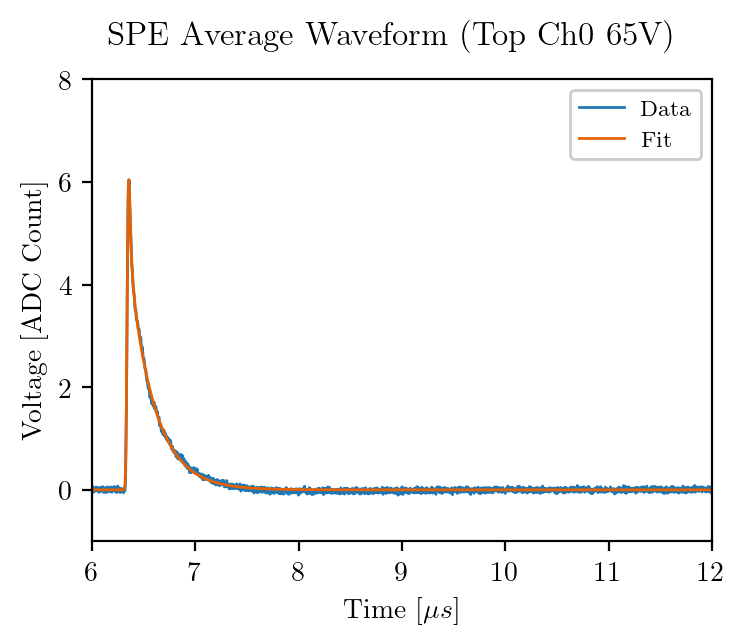

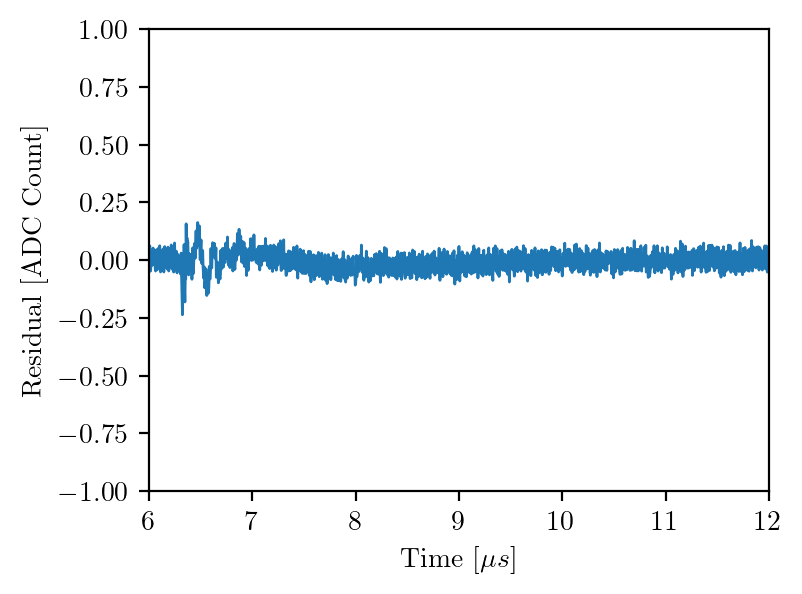

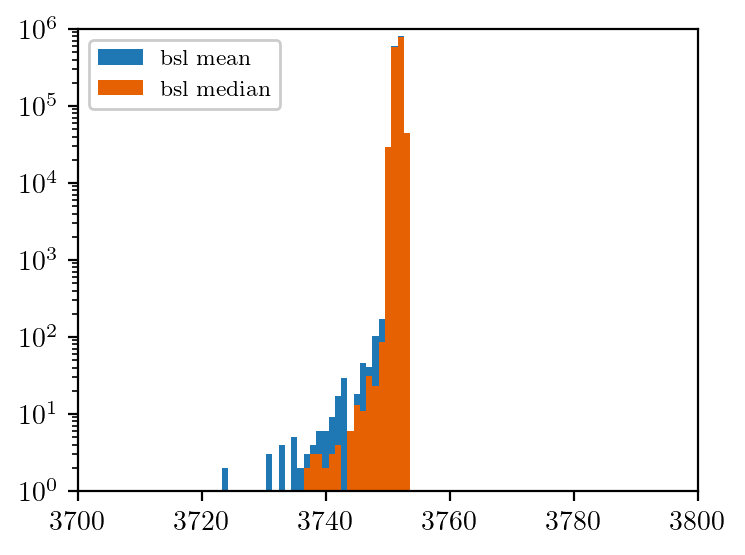

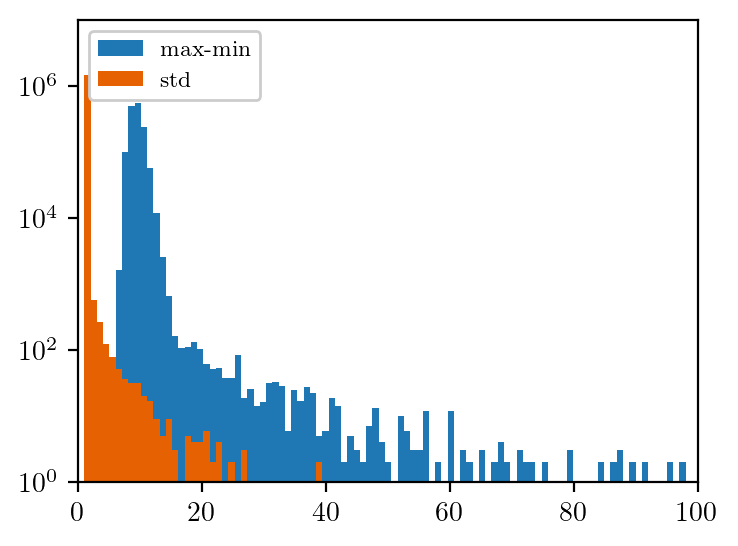

In [54]:
ch=0
dset = ds1115top[0].ch[ch]

print(np.std(dset.spe_avgwf[:dset.baseline_samples]))
print(dset.baseline_samples*dset.sample_step, np.mean(dset.spe_avgwf[:dset.baseline_samples]), np.median(dset.spe_avgwf[:dset.baseline_samples]))
print(np.mean(dset.spe_avgwf[int(12/dset.sample_step):]), np.median(dset.spe_avgwf[int(12/dset.sample_step):]))

plt.figure(0)
plt.plot(dset.time, dset.spe_avgwf, label='Data', linewidth=1)
plt.plot(dset.time, dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0096,6.340), label='Fit', linewidth=1)
residual = dset.spe_avgwf-dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0096,6.340)
plt.ylim(-1, 8)
plt.xlim(6,12)
plt.legend(loc='upper right')
# plt.yscale('log')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Count]')
plt.suptitle('SPE Average Waveform (Top Ch{} 65V)'.format(ch))

plt.figure(1)
plt.plot(dset.time, residual, linewidth=1)
plt.ylim(-1, 1)
plt.xlim(6,12)
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Residual [ADC Count]')

plt.figure(2)
plt.hist(dset.baseline_mean, label='bsl mean', bins=np.linspace(3700,3800,100), linewidth=1)
plt.hist(dset.baseline_median, label='bsl median', bins=np.linspace(3700,3800,100), linewidth=1)
plt.legend()
plt.yscale('log')

plt.figure(3)
plt.hist(np.array(dset.baseline_max)-np.array(dset.baseline_min), label='max-min', bins=np.linspace(0,100,100))
plt.hist(dset.baseline_std, label='std', bins=np.linspace(0,100,100))
plt.legend()
plt.yscale('log')

Text(0.5, 0.98, 'Top Chamber 11/15')

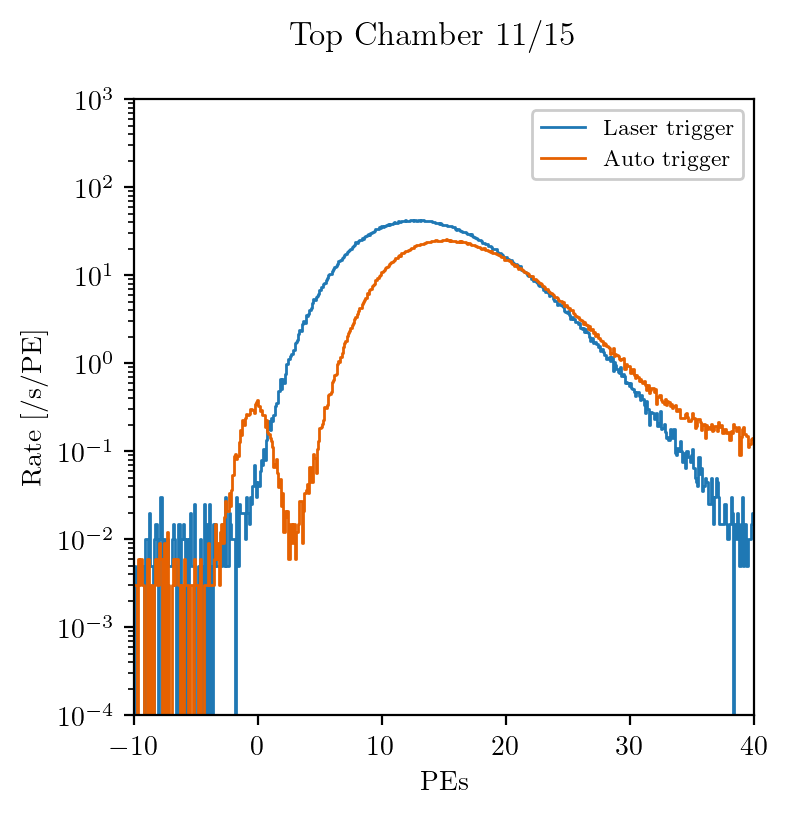

In [14]:
xmin = -10
xmax = 40
nbins = 500
bin_width = (xmax-xmin)/nbins

hist = []
hist_bins = []
labels = ['Laser trigger', 'Auto trigger']
plt.figure(0,figsize=(4,4))
for j in [0,1]:
    dset = ds1115top[j]
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    h = h/dset.ch[0].cumulative_time/bin_width
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label=labels[j], linewidth=1)

plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-4, 1e3)
plt.xlabel('PEs')
plt.ylabel('Rate [/s/PE]')
plt.suptitle('Top Chamber 11/15')

# High stat calibration data (11/16 bottom 65V)

In [4]:
dir1116bot = ['/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-16/2022-11-16_volt_65_pos_bottom_light_laser_coinc_laser_cond_calibration/','/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-16/2022-11-16_volt_65_pos_bottom_light_laser_coinc_111_cond_calibration/']

In [5]:
ds1116bot = [] #[laser trigger, coinc trigger]
for i,dir in enumerate(dir1116bot):
    data = ds.Dataset('', pol=-1, channels=range(4), samples=4000, spe=[550,550,550,550])
    for j in range(20):
        for ch in range(4):
            data.ch[ch].path = "{}{}/".format(dir, j)
            data.ch[ch].read_data(header=True)
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].ar_filter(tau=20)
            data.ch[ch].get_famp()
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    ds1116bot.append(data)

mu=2.481 p=0.195
mu=2.279 p=0.171
mu=3.620 p=0.169
mu=3.638 p=0.177


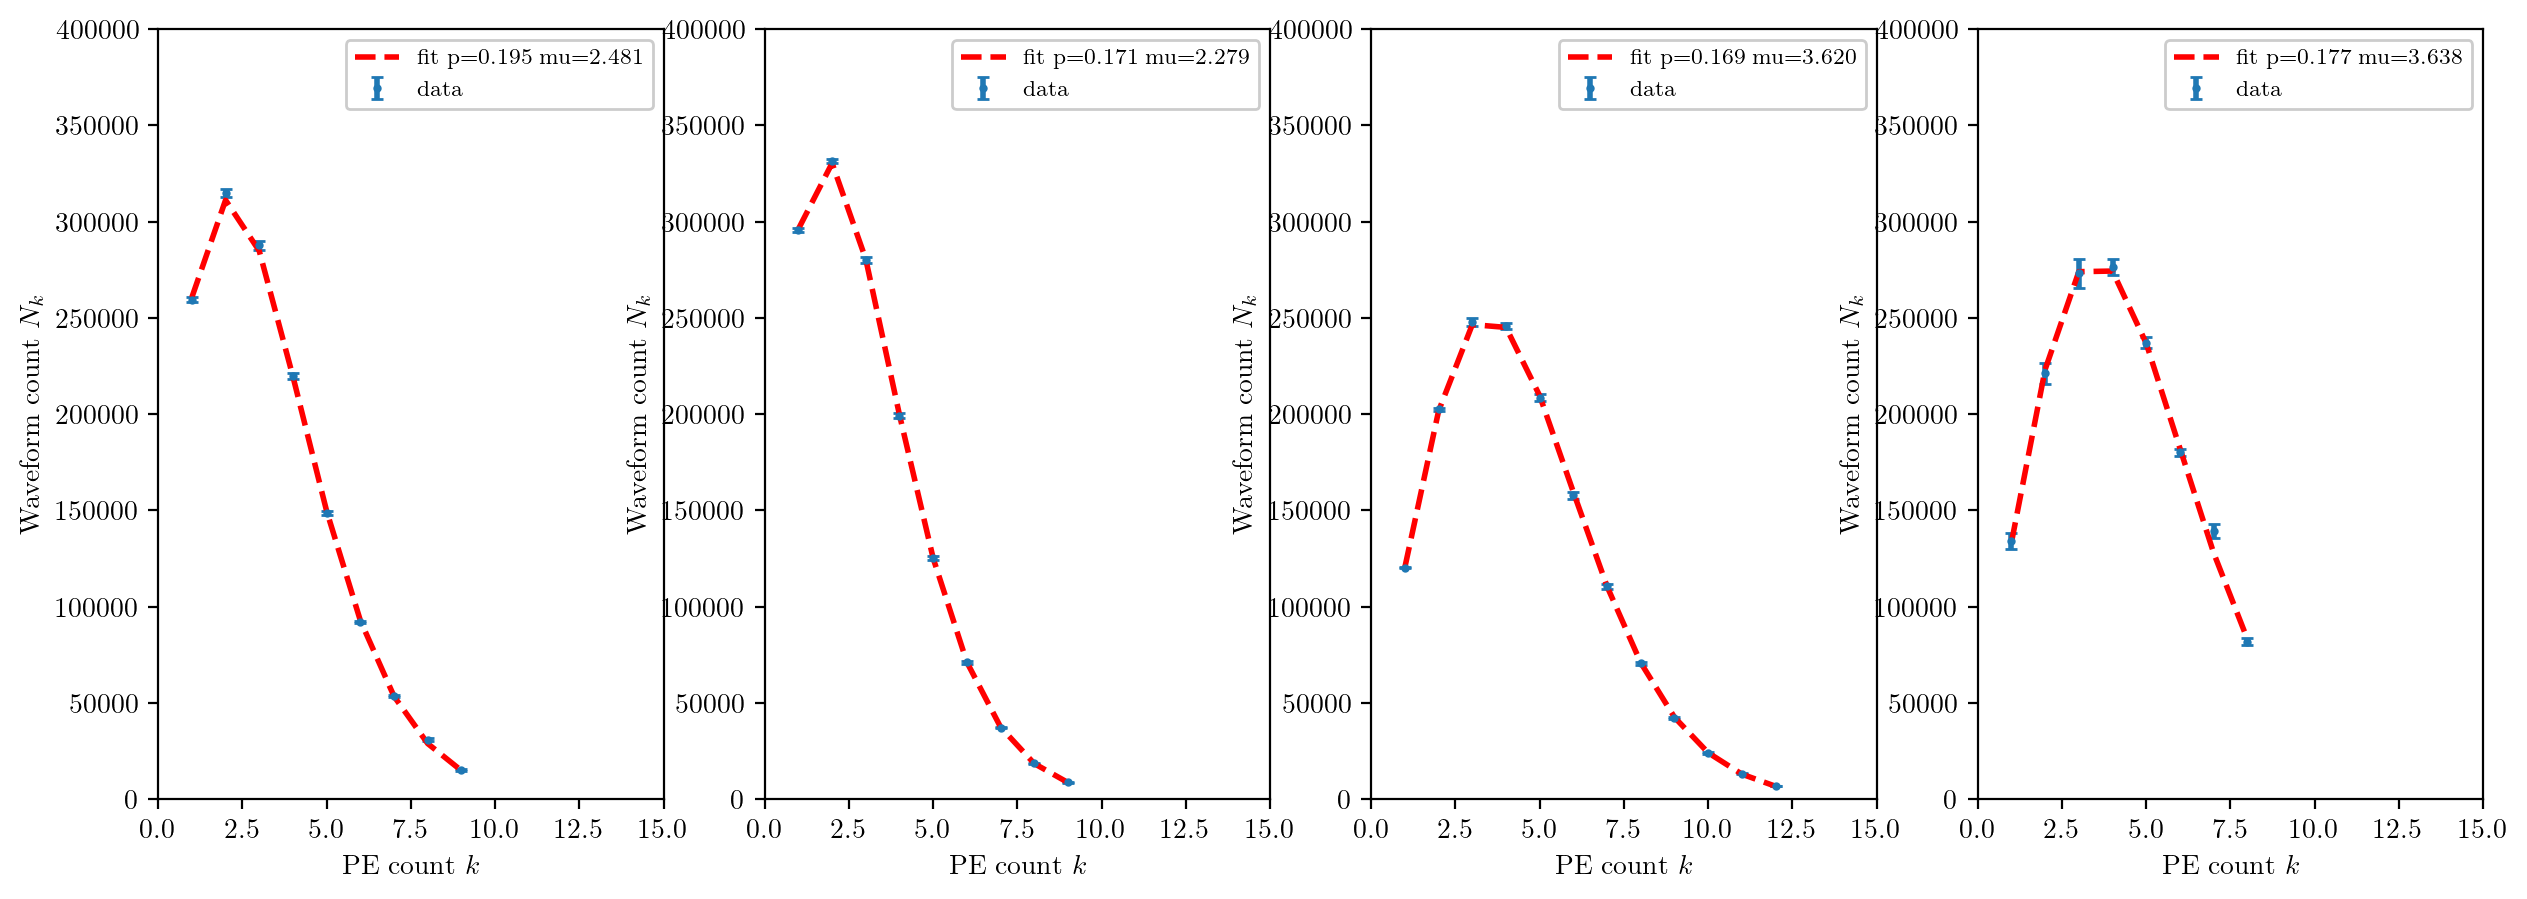

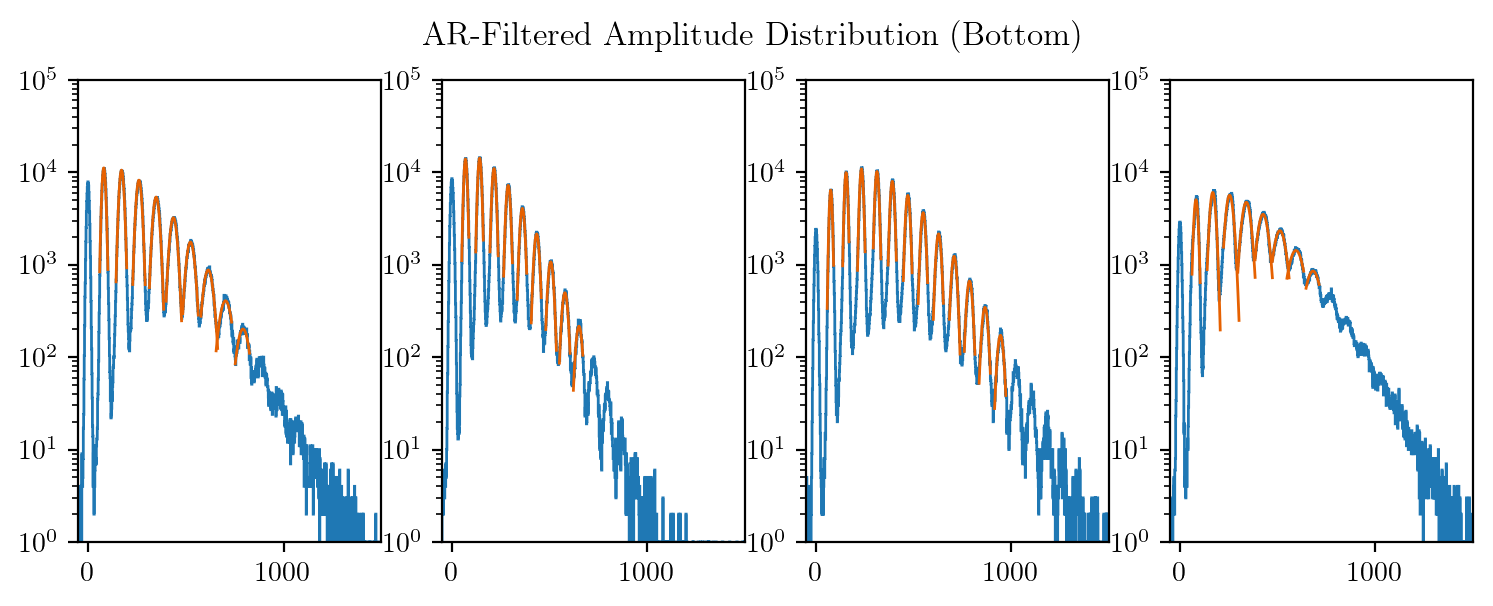

In [16]:
plt.figure(0,figsize=(9,3)) # for filtered amplitude histograms
plt.figure(2,figsize=(15,5)) # for Vinogradov fit
for ch in range(4):
    dset = ds1116bot[0]
    #filtered amplitude histogram
    dset.ch[ch].get_famp_hist(bin=[-50,1.5e3,1000])
    plt.figure(0)
    plt.subplot(1,4,ch+1)
    plt.suptitle('Channel {}'.format(ch))
    plt.stairs(dset.ch[ch].famp_hist, dset.ch[ch].famp_hist_bin)
    plt.yscale('log')
    plt.xlim(dset.ch[ch].famp_hist_bin[0], dset.ch[ch].famp_hist_bin[-1])
    plt.ylim(1, 1e5)
    # find pe peaks in histograms
    dset.ch[ch].find_histo_peaks(hist='famp', thre=40, prom=100, wid=8, dist=8)
    # fit pe peaks with Gaussian
    min_bins, max_bins = dset.ch[ch].fit_histo_peaks(hist='famp')
    npe = len(dset.ch[ch].famp_hist_fit)
    for ipe in range(npe):
        popt = [dset.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
        plt.plot(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
    #fit pe-mean vs pe with linear
    Afilt = [[dset.ch[ch].famp_hist_fit[k][1][0], dset.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
    xlin = np.linspace(1,npe,npe)
    ylin = np.array(Afilt)[:,0]
    popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
    dset.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
    #Vinogradov fit
    plt.figure(2)
    plt.subplot(1,4,ch+1)
    N_k = [dset.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
    plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
    popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[dset.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
    print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
    dset.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
    plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
    plt.ylim(0,0.4*dset.ch[ch].cumulative_nevents)
    plt.xlim(0,15)
    plt.xlabel(r'PE count $k$')
    plt.ylabel(r'Waveform count $N_k$')
    plt.legend(loc='upper right')

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
plt.savefig('plots/sipm/famp_histo_bot_1116.pdf')

Q_avg = 556.997+/-1.566
Q_avg = 503.579+/-0.713
Q_avg = 549.769+/-0.814
Q_avg = 558.519+/-4.502


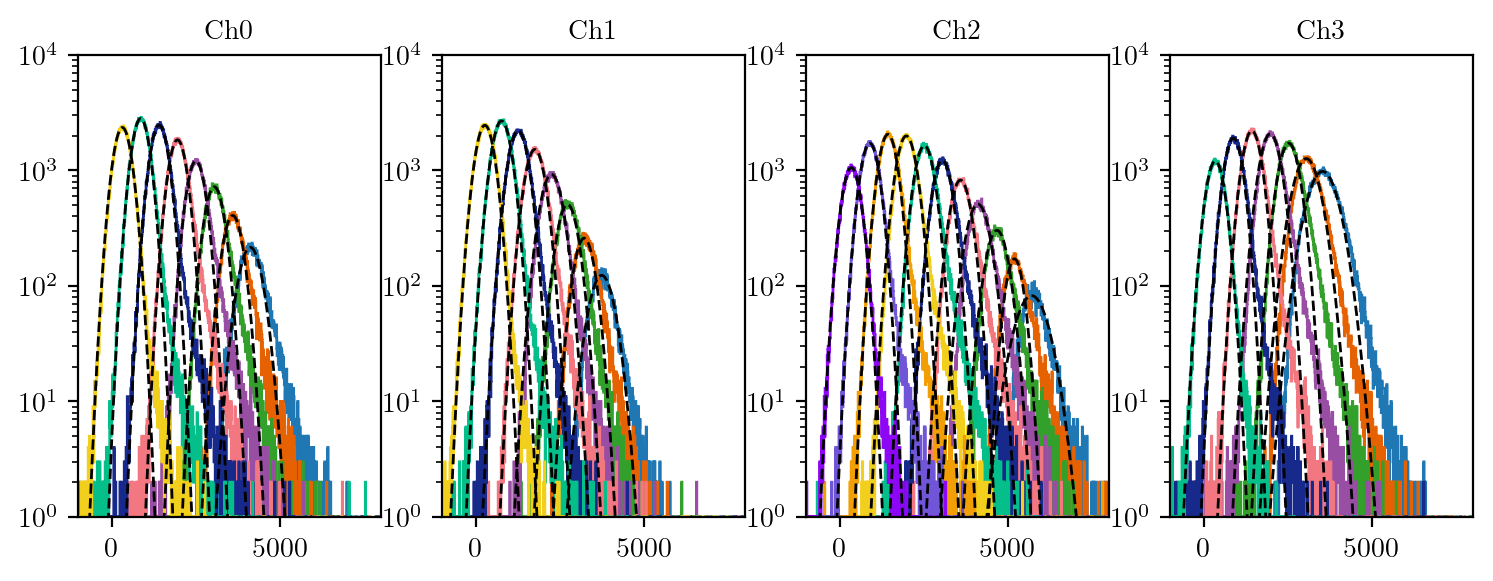

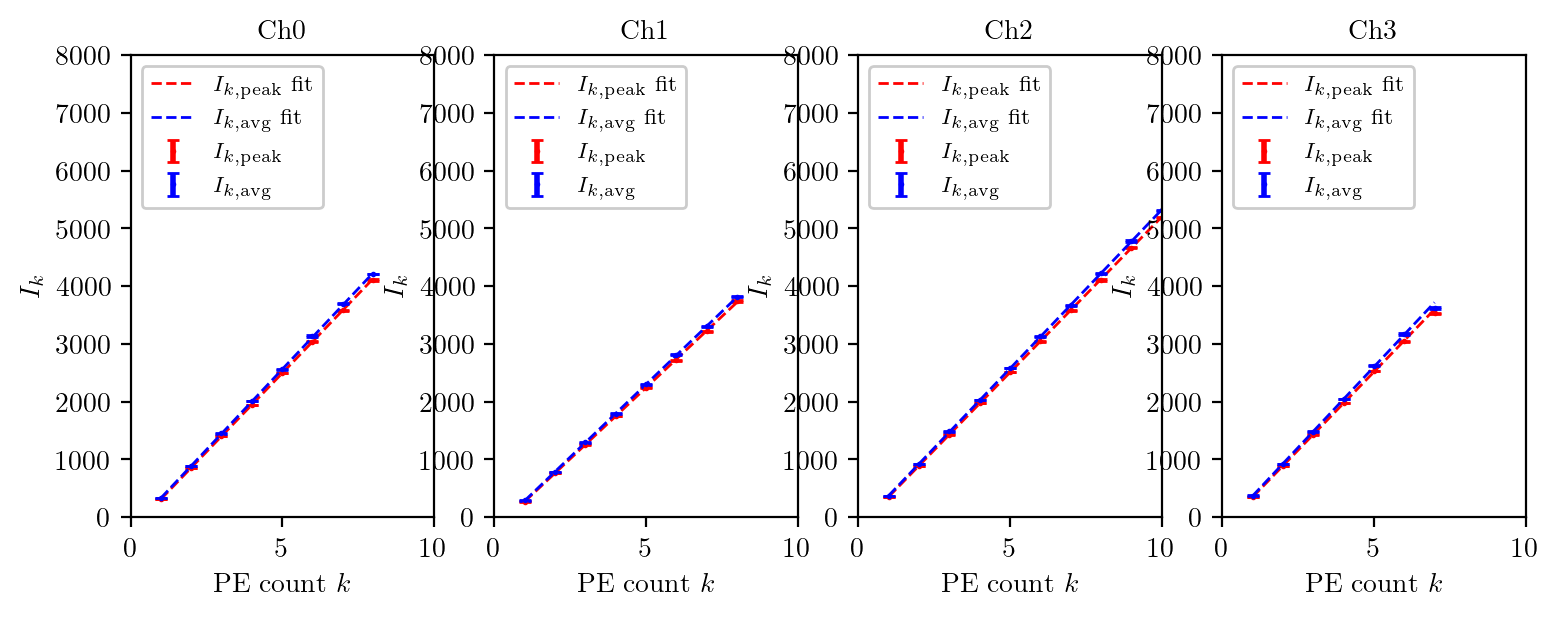

In [17]:
plt.figure(0,figsize=(9,3)) # for I_k histograms
plt.figure(1,figsize=(9,3)) # for I_k fits
x_min=-1000
x_max=8000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
dset = ds1116bot[0]
for ch in range(4):
    Ik_peak = [] 
    Ik_avg = []
    dset.ch[ch].get_afterpulse_charge(nsigma=2, bin=[x_min, x_max, n_bins])
    #histogram and Gaussian fit
    plt.figure(0)
    plt.subplot(1,4,ch+1)
    plt.title('Ch{}'.format(ch))
    for j in np.arange(len(dset.ch[ch].ap_charge)-2,-1,-1):
        plt.stairs(dset.ch[ch].ap_charge_hist[j], dset.ch[ch].ap_charge_hist_bin[j])
        Ik_avg.append([np.mean(dset.ch[ch].ap_charge[j]), np.std(dset.ch[ch].ap_charge[j])/np.sqrt(len(dset.ch[ch].ap_charge[j]))])
        w = int(np.std(dset.ch[ch].ap_charge[j])/bin_width) # in bins
        p = np.argmax(dset.ch[ch].ap_charge_hist[j]) # in bins
        if w>0.1*(p+x_min/bin_width):
            w=20 # something weird happened so I need to do this
        popt,pcov = curve_fit(gauss, dset.ch[ch].ap_charge_hist_bin[j][p-w:p+w], dset.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(dset.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(dset.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
        plt.plot(dset.ch[ch].ap_charge_hist_bin[j][:-1], gauss(dset.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
        Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
    plt.xlim(dset.ch[ch].ap_charge_hist_bin[0][0], dset.ch[ch].ap_charge_hist_bin[0][-1])
    plt.ylim(1,1e4)
    plt.yscale('log')
    # plot mu-pe vs avg-pe
    Ik_peak = list(reversed(Ik_peak))
    Ik_avg = list(reversed(Ik_avg))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Ch{}'.format(ch))
    # Q_peak fit
    plt.errorbar(np.arange(len(dset.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
    popt,pcov=curve_fit(line,np.arange(len(dset.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
    # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
    dset.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
    plt.plot(np.arange(len(dset.ch[ch].ap_charge)-1)+1, line(np.arange(len(dset.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
    # Q_avg fit
    plt.errorbar(np.arange(len(dset.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
    popt_,pcov_=curve_fit(line,np.arange(len(dset.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
    print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
    dset.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
    plt.plot(np.arange(len(dset.ch[ch].ap_charge)-1)+1, line(np.arange(len(dset.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
    plt.xlabel(r'PE count $k$')
    plt.ylabel(r'$I_k$')
    dset.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
    plt.xlim(0,15)
    plt.ylim(0,8000)
    plt.legend()

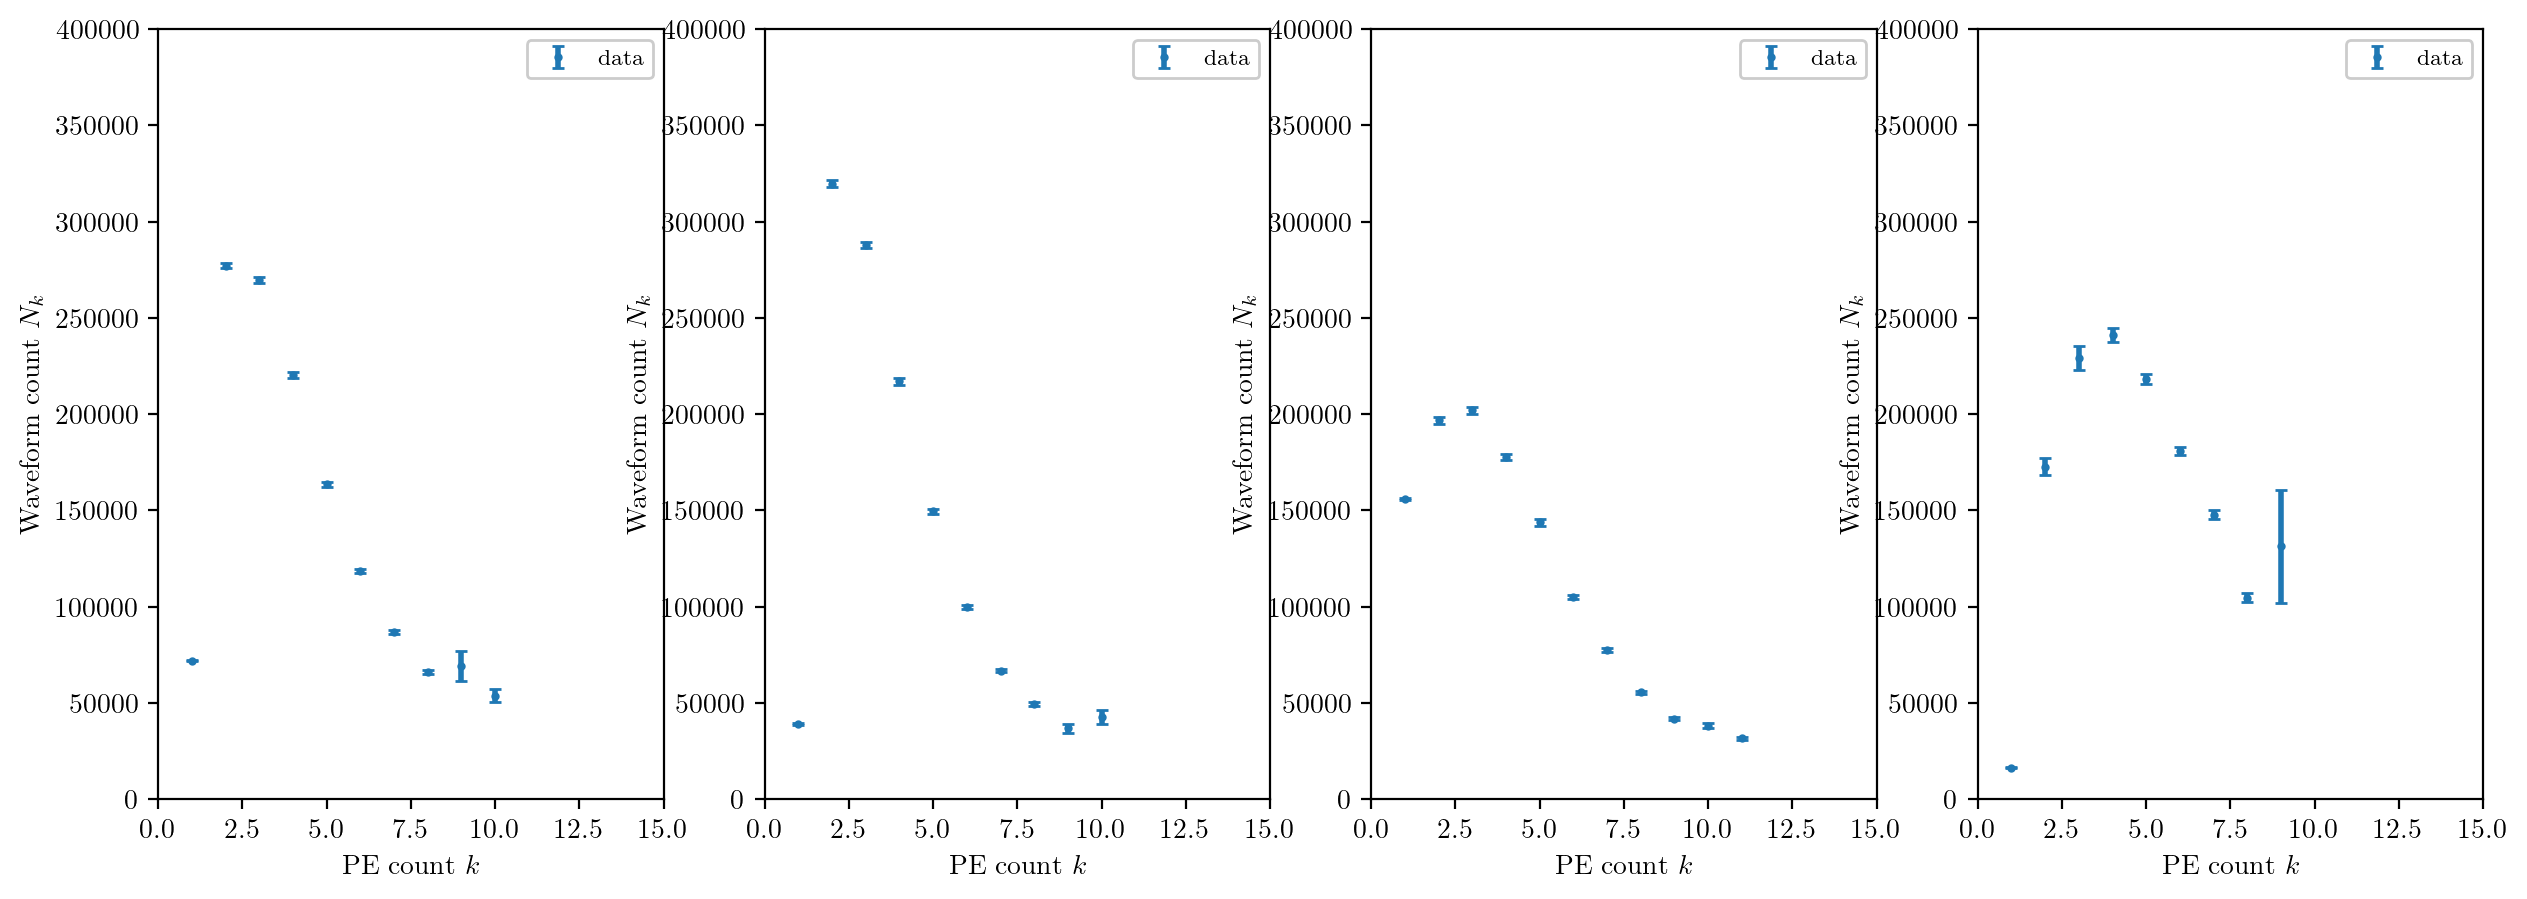

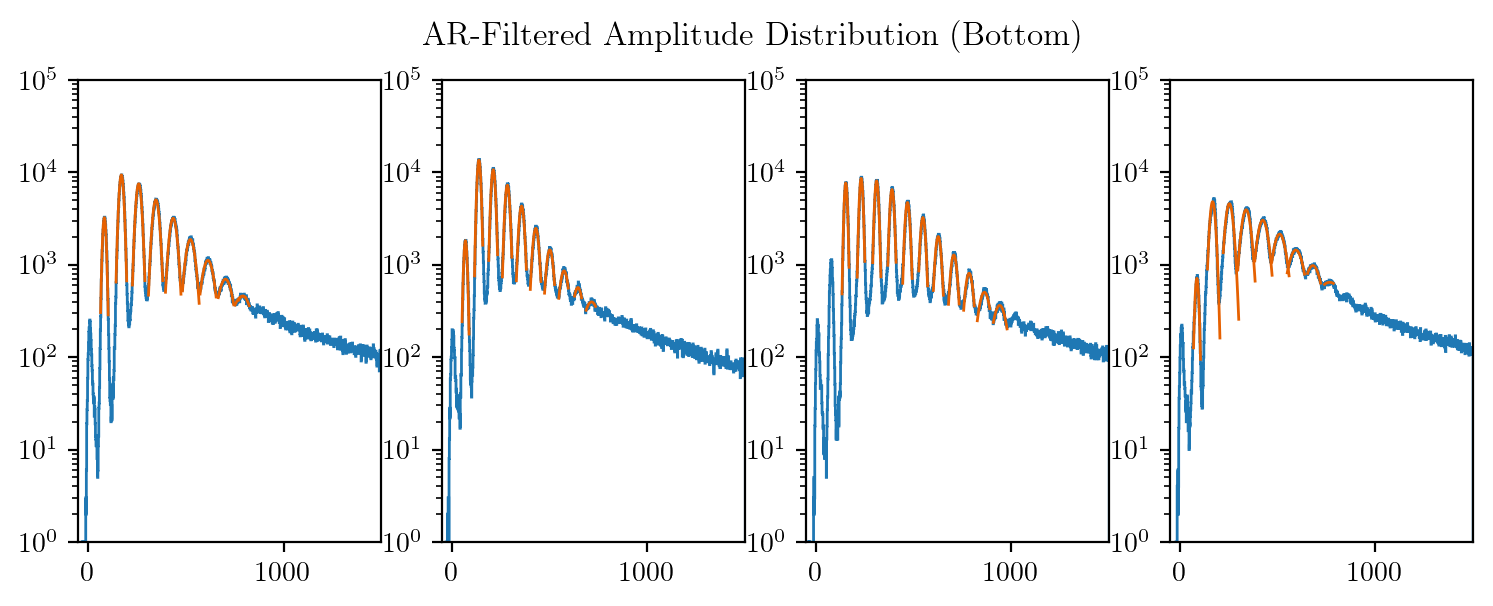

In [19]:
plt.figure(0,figsize=(9,3)) # for filtered amplitude histograms
plt.figure(2,figsize=(15,5)) # for Vinogradov fit
dset = ds1116bot[1]
for ch in range(4):
    #filtered amplitude histogram
    dset.ch[ch].get_famp_hist(bin=[-50,1.5e3,1000])
    plt.figure(0)
    plt.subplot(1,4,ch+1)
    plt.suptitle('Channel {}'.format(ch))
    plt.stairs(dset.ch[ch].famp_hist, dset.ch[ch].famp_hist_bin)
    plt.yscale('log')
    plt.xlim(dset.ch[ch].famp_hist_bin[0], dset.ch[ch].famp_hist_bin[-1])
    plt.ylim(1, 1e5)
    # find pe peaks in histograms
    dset.ch[ch].find_histo_peaks(hist='famp', thre=40, prom=100, wid=12, dist=8)
    # fit pe peaks with Gaussian
    min_bins, max_bins = dset.ch[ch].fit_histo_peaks(hist='famp')
    npe = len(dset.ch[ch].famp_hist_fit)
    for ipe in range(npe):
        popt = [dset.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
        plt.plot(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(dset.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
    #fit pe-mean vs pe with linear
    # Afilt = [[dset.ch[ch].famp_hist_fit[k][1][0], dset.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
    # xlin = np.linspace(1,npe,npe)
    # ylin = np.array(Afilt)[:,0]
    # popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
    # dset.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
    #Vinogradov fit
    plt.figure(2)
    plt.subplot(1,4,ch+1)
    N_k = [dset.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
    plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
    # popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[dset.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
    # print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
    # dset.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
    # plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
    plt.ylim(0,0.4*dset.ch[ch].cumulative_nevents)
    plt.xlim(0,15)
    plt.xlabel(r'PE count $k$')
    plt.ylabel(r'Waveform count $N_k$')
    plt.legend(loc='upper right')

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
plt.savefig('plots/sipm/famp_histo_bot_1116_coinc.pdf')

CH0 65V A1=3.096+/-0.028 TAU1=0.4040+/-0.0032us A2=4.031+/-0.054 TAU2=0.0475+/-0.0012us sigma=0.0090+/-0.0001us t0=6.340+/-0.000us
Chi square/DoF = 1.911
[3.0961502912281684,0.40403299656617736,4.031301888928057,0.0474947403947006]
CH1 65V A1=0.570+/-0.012 TAU1=1.1390+/-0.0257us A2=5.741+/-0.032 TAU2=0.0842+/-0.0008us sigma=0.0082+/-0.0002us t0=6.339+/-0.000us
Chi square/DoF = 2.168
[0.5703764778401712,1.139009653925973,5.741446984162888,0.08418902284102635]
CH2 65V A1=1.448+/-0.019 TAU1=0.7148+/-0.0086us A2=5.149+/-0.033 TAU2=0.0765+/-0.0010us sigma=0.0081+/-0.0001us t0=6.338+/-0.000us
Chi square/DoF = 1.669
[1.4484382154664293,0.7148347202664096,5.1493499838224,0.07648178637862194]
CH3 65V A1=0.784+/-0.019 TAU1=1.0141+/-0.0224us A2=5.759+/-0.030 TAU2=0.1112+/-0.0011us sigma=0.0082+/-0.0002us t0=6.339+/-0.000us
Chi square/DoF = 1.952
[0.7838514098331236,1.0140621739648736,5.759044453901097,0.11122538237449603]


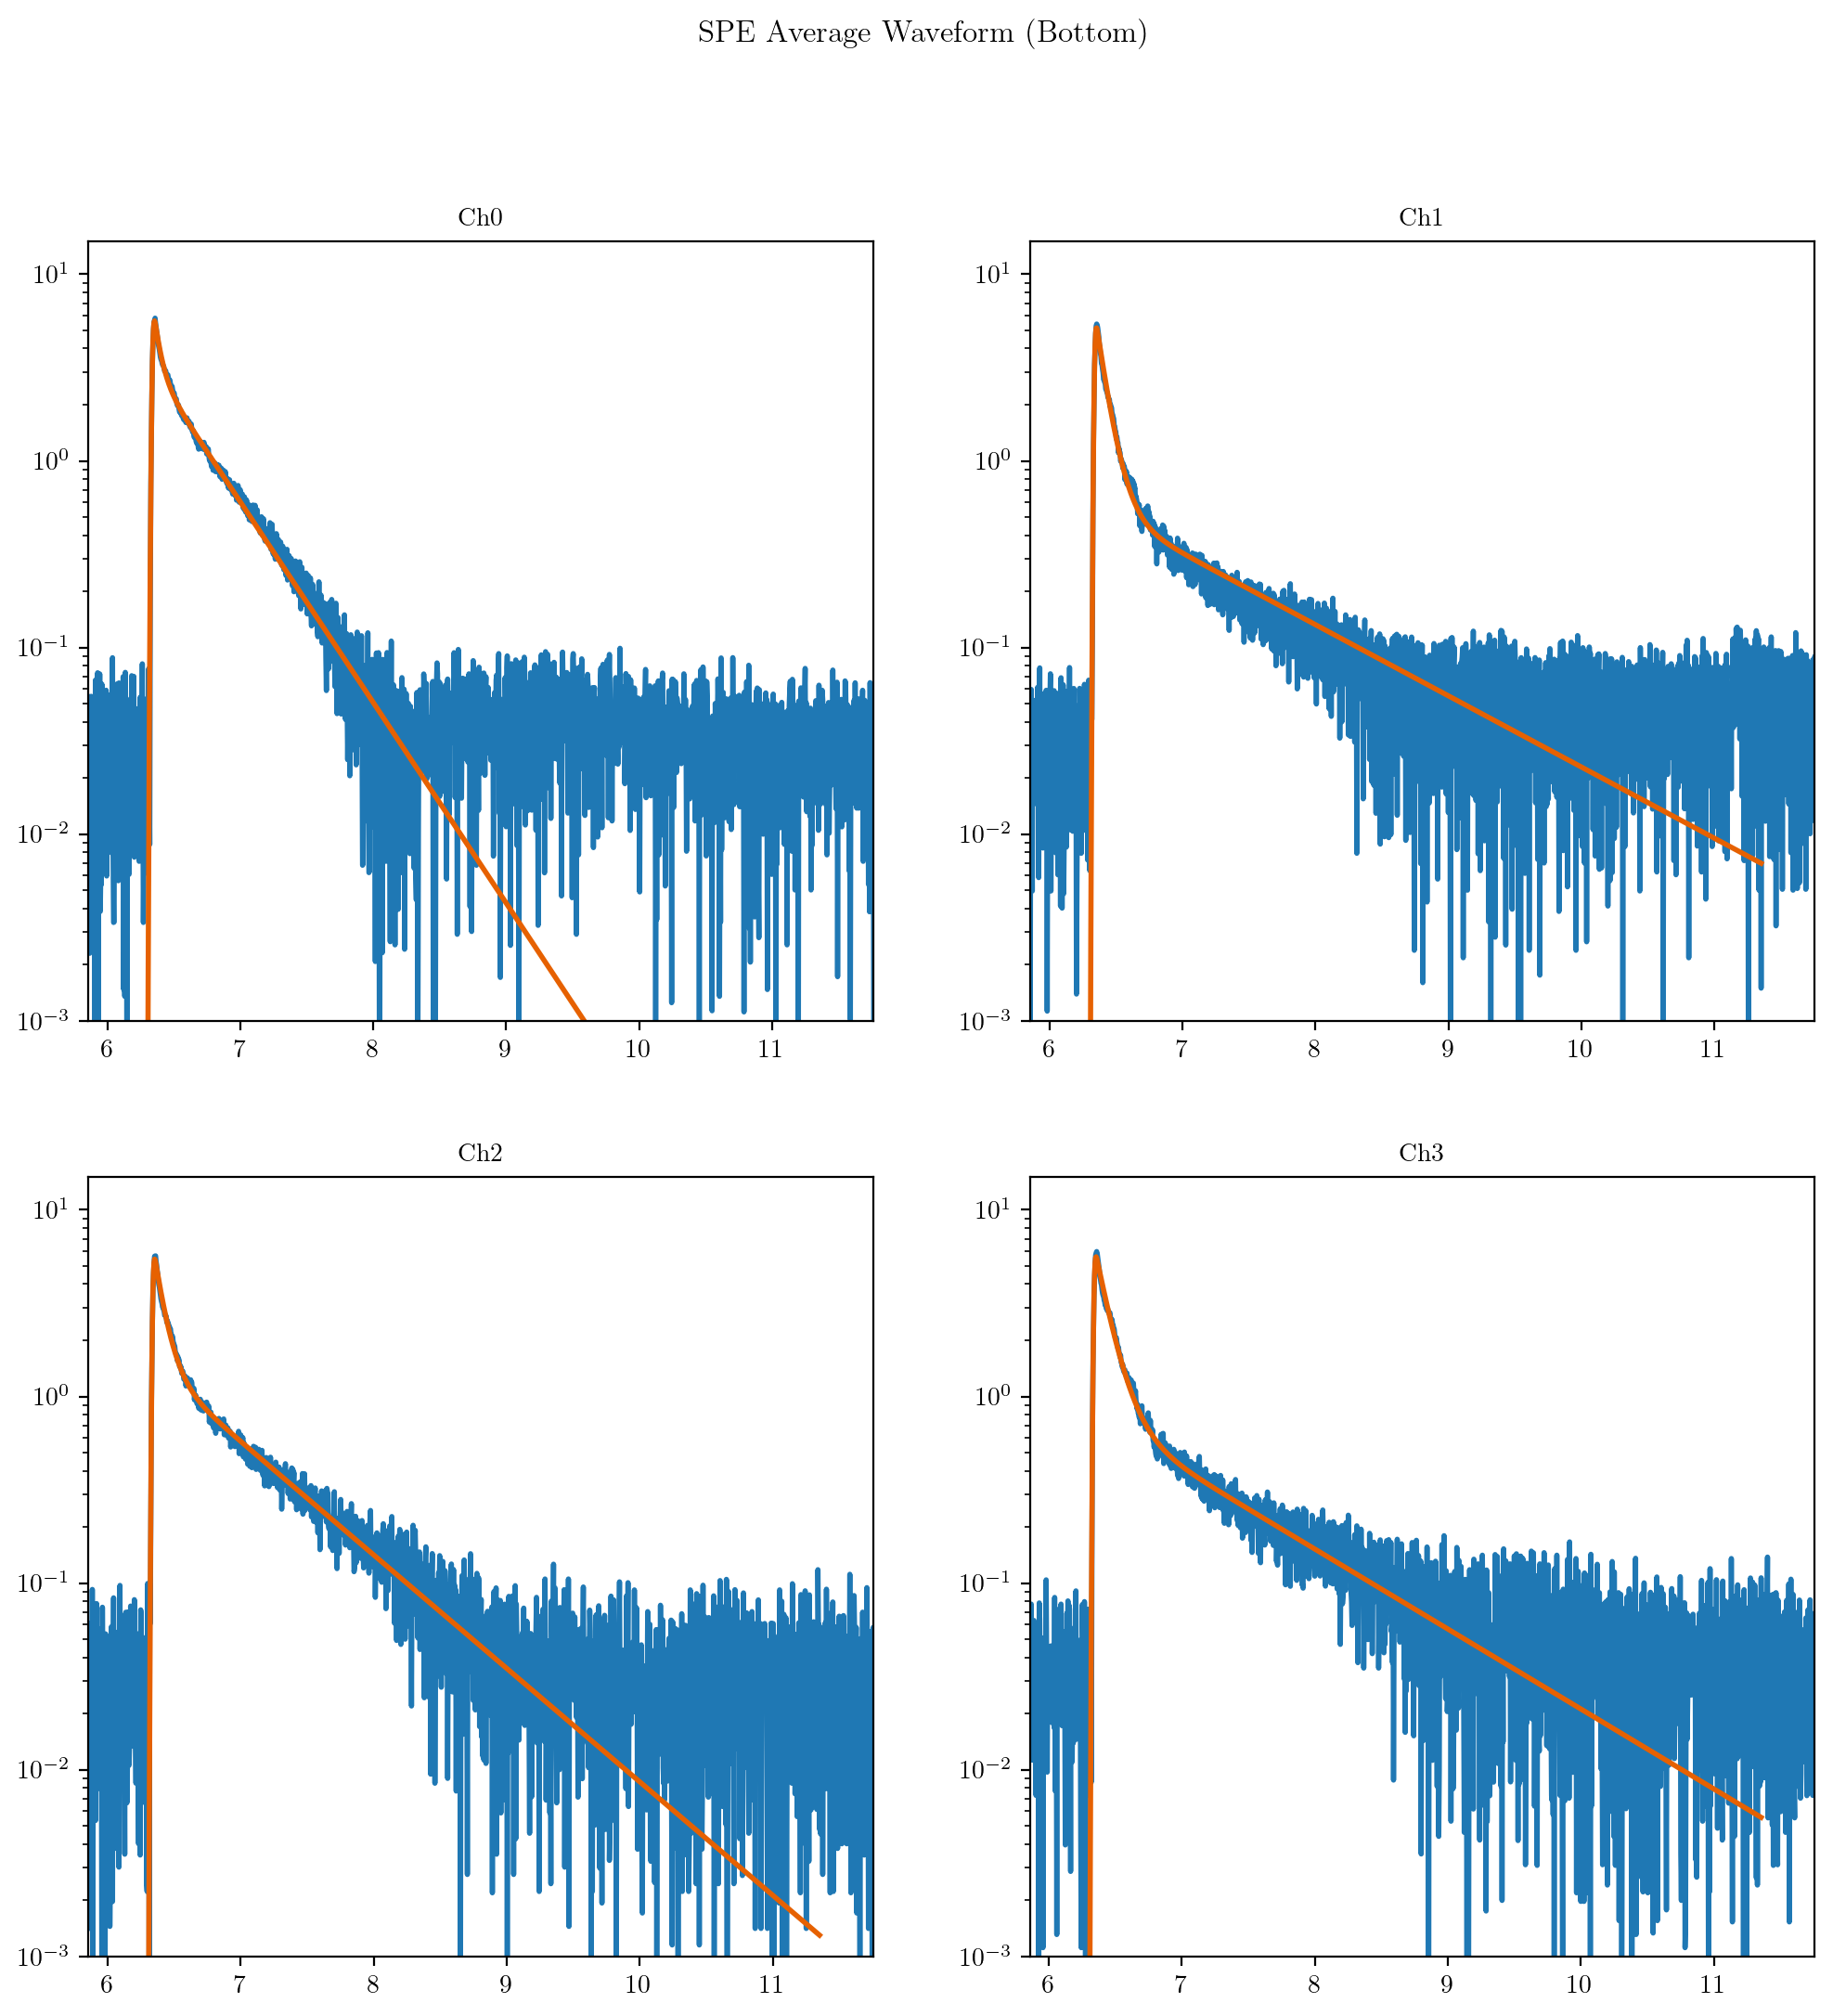

In [10]:
#for spe average waveforms
plt.figure(0,figsize=(12,12))
dset = ds1116bot[0]
for ch in range(4):
    spe_integral = []
    dset.ch[ch].get_spe_avgwf()
    dset.ch[ch].clear()
    plt.subplot(2,2,ch+1)
    plt.title('Ch{}'.format(ch))
    plt.plot(dset.ch[ch].time, abs(dset.ch[ch].spe_avgwf))
    t_start = int(dset.ch[ch].trigger_position - 0.1/dset.ch[ch].sample_step)
    t_end = int(dset.ch[ch].trigger_position + 5/dset.ch[ch].sample_step)
    err = np.std(dset.ch[ch].spe_avgwf[:dset.ch[ch].baseline_samples])
    popt,pcov = curve_fit(dset.ch[ch].get_pulse_shape, dset.ch[ch].time[t_start:t_end], dset.ch[ch].spe_avgwf[t_start:t_end], p0=[3,0.4,4,0.01,0.007,6.34], sigma=[err]*len(dset.ch[ch].time[t_start:t_end]), maxfev=10000)
    plt.plot(dset.ch[ch].time[t_start:t_end], dset.ch[ch].get_pulse_shape(dset.ch[ch].time[t_start:t_end],*popt))
    print('CH{} 65V A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    chi2 = np.sum((dset.ch[ch].spe_avgwf[t_start:t_end]-dset.ch[ch].get_pulse_shape(dset.ch[ch].time[t_start:t_end],*popt))**2)/(t_end-t_start-6)/err**2
    print('Chi square/DoF = {:.3f}'.format(chi2))
    dset.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
    print('[{},{},{},{}]'.format(*dset.ch[ch].get_pulse_pars()))
    plt.xlim((t_start-100)*dset.ch[ch].sample_step,(t_end+100)*dset.ch[ch].sample_step)
    plt.ylim(1e-3, 15)
    plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
plt.savefig('plots/sipm/spewf_bot_1116.pdf')

0.03801727295166385
5.86 2.003516806384135e-15 -0.00941258022337984
0.014184291443879303 0.00409612933936458


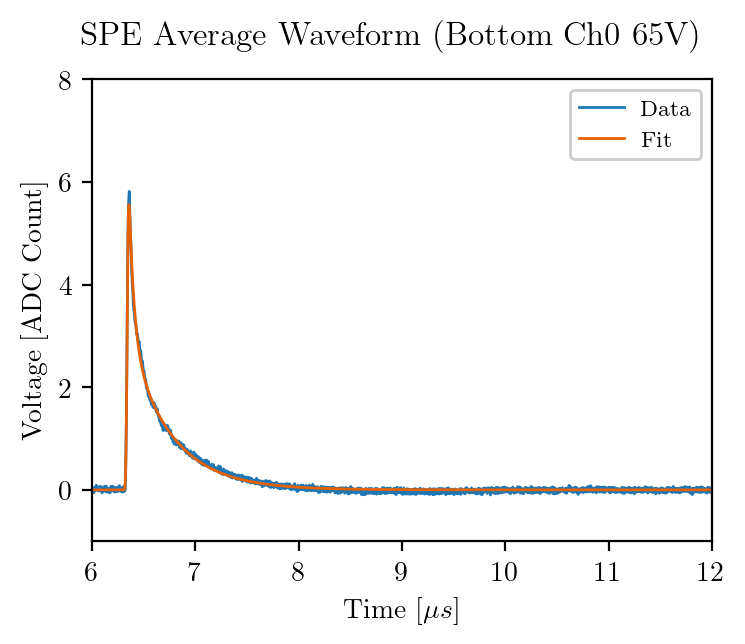

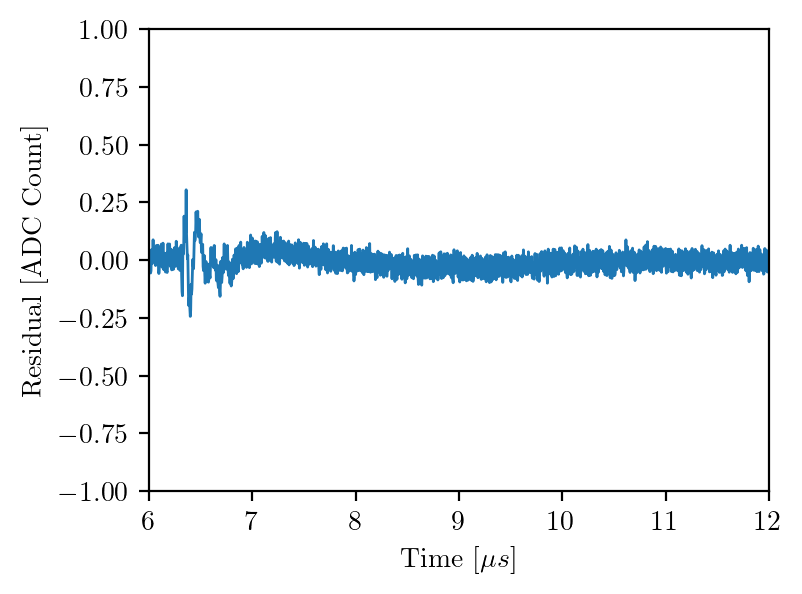

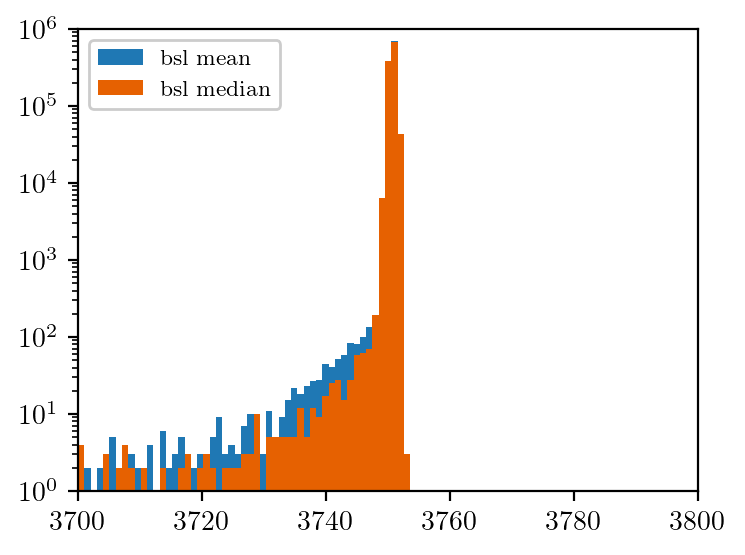

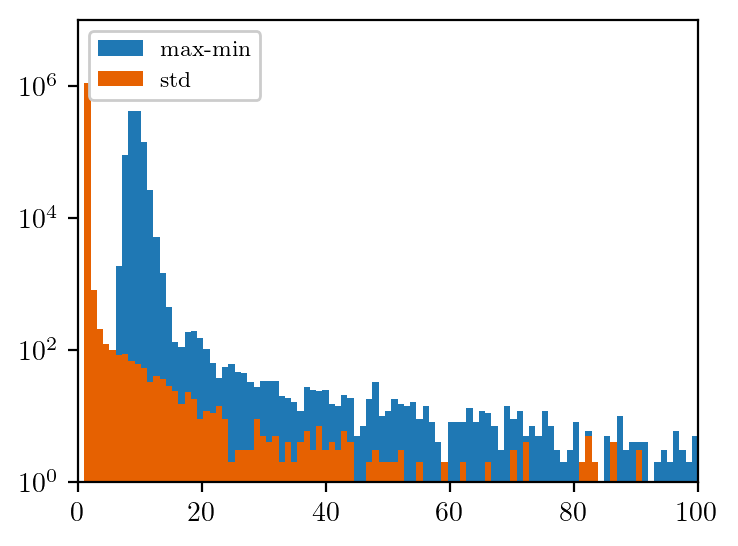

In [11]:
ch=0
dset = ds1116bot[0].ch[ch]

print(np.std(dset.spe_avgwf[:dset.baseline_samples]))
print(dset.baseline_samples*dset.sample_step, np.mean(dset.spe_avgwf[:dset.baseline_samples]), np.median(dset.spe_avgwf[:dset.baseline_samples]))
print(np.mean(dset.spe_avgwf[int(12/dset.sample_step):]), np.median(dset.spe_avgwf[int(12/dset.sample_step):]))

plt.figure(0)
plt.plot(dset.time, dset.spe_avgwf, label='Data', linewidth=1)
plt.plot(dset.time, dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0096,6.340), label='Fit', linewidth=1)
residual = dset.spe_avgwf-dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0096,6.340)
plt.ylim(-1, 8)
plt.xlim(6,12)
plt.legend(loc='upper right')
# plt.yscale('log')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Count]')
plt.suptitle('SPE Average Waveform (Bottom Ch{} 65V)'.format(ch))

plt.figure(1)
plt.plot(dset.time, residual, linewidth=1)
plt.ylim(-1, 1)
plt.xlim(6,12)
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Residual [ADC Count]')

plt.figure(2)
plt.hist(dset.baseline_mean, label='bsl mean', bins=np.linspace(3700,3800,100), linewidth=1)
plt.hist(dset.baseline_median, label='bsl median', bins=np.linspace(3700,3800,100), linewidth=1)
plt.legend()
plt.yscale('log')

plt.figure(3)
plt.hist(np.array(dset.baseline_max)-np.array(dset.baseline_min), label='max-min', bins=np.linspace(0,100,100))
plt.hist(dset.baseline_std, label='std', bins=np.linspace(0,100,100))
plt.legend()
plt.yscale('log')